<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>


### Rigid Transformations in Lower Dimensional Space for Subsurface Uncertainty Quantification and Interpretation


#### Midé Mabadeje$^{1}$ (PhD Candidate) & Michael Pyrcz$^{1,2}$ (Professor), University of Texas at Austin

 1. Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

 2. Department of Earth and Planetary Sciences, Jackson School of Geosciences


## Introduction

An example of the workflow as applied on South Kaybob field from the Duvernay formation. The datset was provided by Equinor but not included in the repository.

## Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/).
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal.
3. In the terminal type: pip install geostatspy.
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality.

### Import Libraries

In [1]:
import numpy as np                        # ndarray for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import seaborn as sns                     # for matrix scatter plots
import matplotlib.pyplot as plt
import RigidTransformation_UQI_OOSP as RT      # imports script consisting of functions to run workflow
import warnings
warnings.filterwarnings('ignore')

In [2]:
get_ipython()

### Set the working directory

In [3]:
%pwd # grab current working directory

'/Users/ademidemabadeje/Documents/UT/Research/PyCharm/LD_Stabilization/Workflows'

In [4]:
os.chdir('/LD_Stabilization/Workflows/Results/Results with new OOSP main script/Duvernay')    # set the working directory to results directory

#### Data

Load kriged production based on sampels in both Euclidean and MDS spaces.

In [5]:
krig_array_lds = np.load('Kriged Cum. Gas in MDS Space.npy') # in LDS
krig_array_euc = np.load('Kriged Cum. Gas in Euclidean Space.npy') # in Euclidean space

Load comma delimited data file into a Pandas' DataFrame object.

This dataset has features from 55 unconventional wells in the Duvernay including:

0. A unique well identifier
1. East (Km) Location coordinate
2. North (Km) Location coordinate
3. Pore Pressure (MPa)
4. Reservoir thickness at given X,Y coordinates
5. Average well porosity (fraction)
6. Oil saturation (fraction)
7. Cumulative gas production (MMscf).


<br>

#### Summary Statistics

Let's check the summary statistics of our data.

In [6]:
df = pd.read_csv('South Kaybob.csv')

In [7]:
os.chdir('/Users/ademidemabadeje/Documents/UT/Research/PyCharm/LD_Stabilization/Fall 2022/Results/')    # set the working directory to results directory

Based on the data summary statistics, establish the feature ranges for plotting.  We could calculate the feature range directly from the data with code like this:

```p
Pormin = np.min(df['Porosity'].values)          # extract ndarray of data table column
Pormax = np.max(df['Porosity'].values)          # and calculate min and max
```

but, this would not result in easy to understand color bars and axis scales, let's pick convenient round numbers. We will also declare feature labels for ease of plotting.

In [9]:
# user specified min and max values, and labels for plotting
pormin = 0.06; pormax = 0.082; porname = 'PHI (fraction)'; portitle = 'Porosity'
presmin = 14.15; presmax = 18.31; presname = 'Pore Pressure (Mpa)'; prestitle = 'Pore Pressure'
thickmin = 28.50; thickmax = 40.25; thickname = 'H (Km)'; thicktitle = 'Thickness'
somin = 0.04; somax = 0.21; soname = 'So (fraction)'; sotitle = 'Oil Saturation'
prodmin = 0.008; prodmax = 2.85; prodname = 'Cum. Gas (MMscf)'; prodtitle = 'Cumulative Gas Production'

In [10]:
# Rename features as needed
df = df.copy(deep=True)
df.rename(columns={'Porosity': porname, 'Pore Pressure': presname, 'Thickness': thickname, 'Oil Saturation': soname, 'Cum. Gas': prodname}, inplace=True)

Summary statistics show data is good as-is. Next, visualize data distributions with a martix scatter plot.

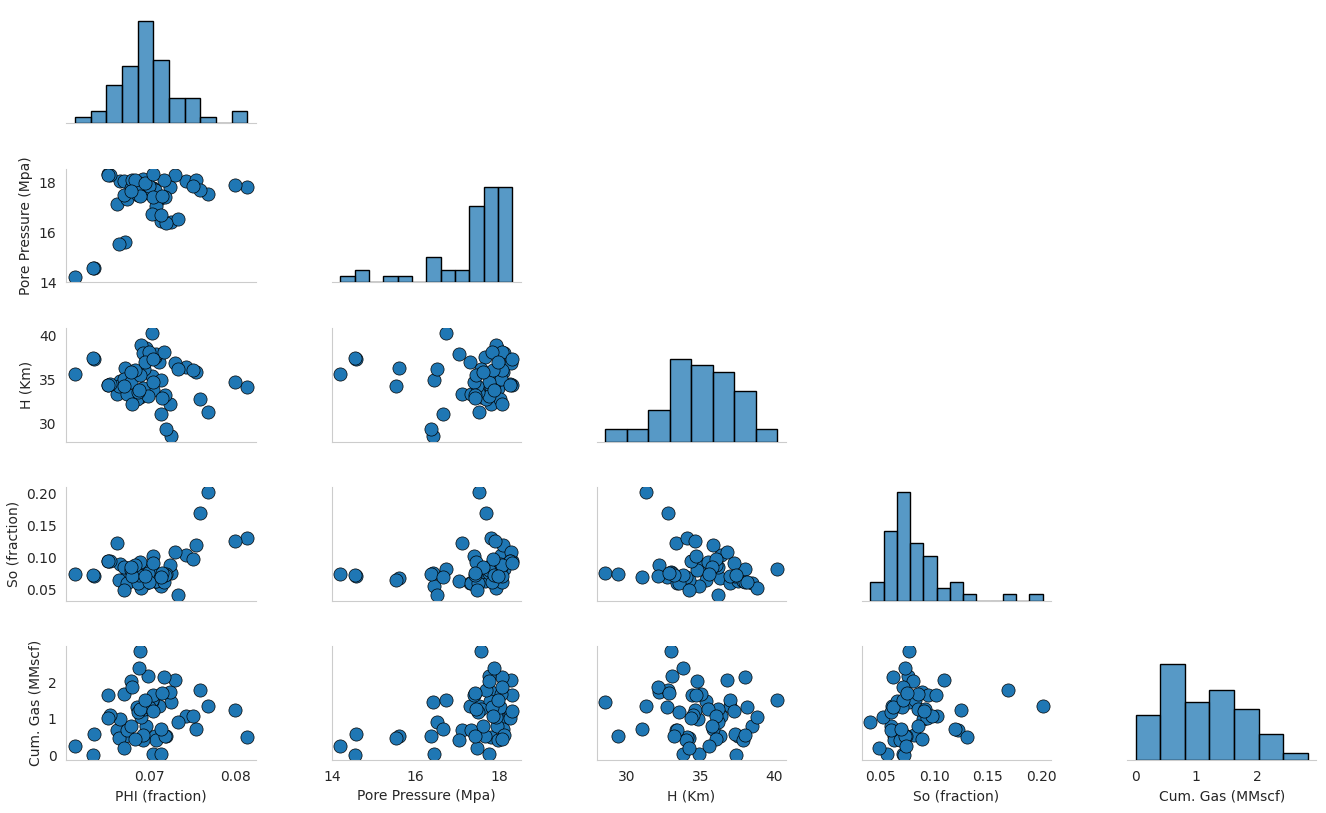

In [11]:
RT.matrix_scatter(df, [porname, presname, thickname, soname, prodname], 0., 0., 1., 0.6, 0.4, 0.4, 'Scatterplot of all features for entire data', 1, hue_=None, num_OOSP=None, n_case=True, save=False)

Visualize the distributions colored by varying levels of production as a categorical variable.

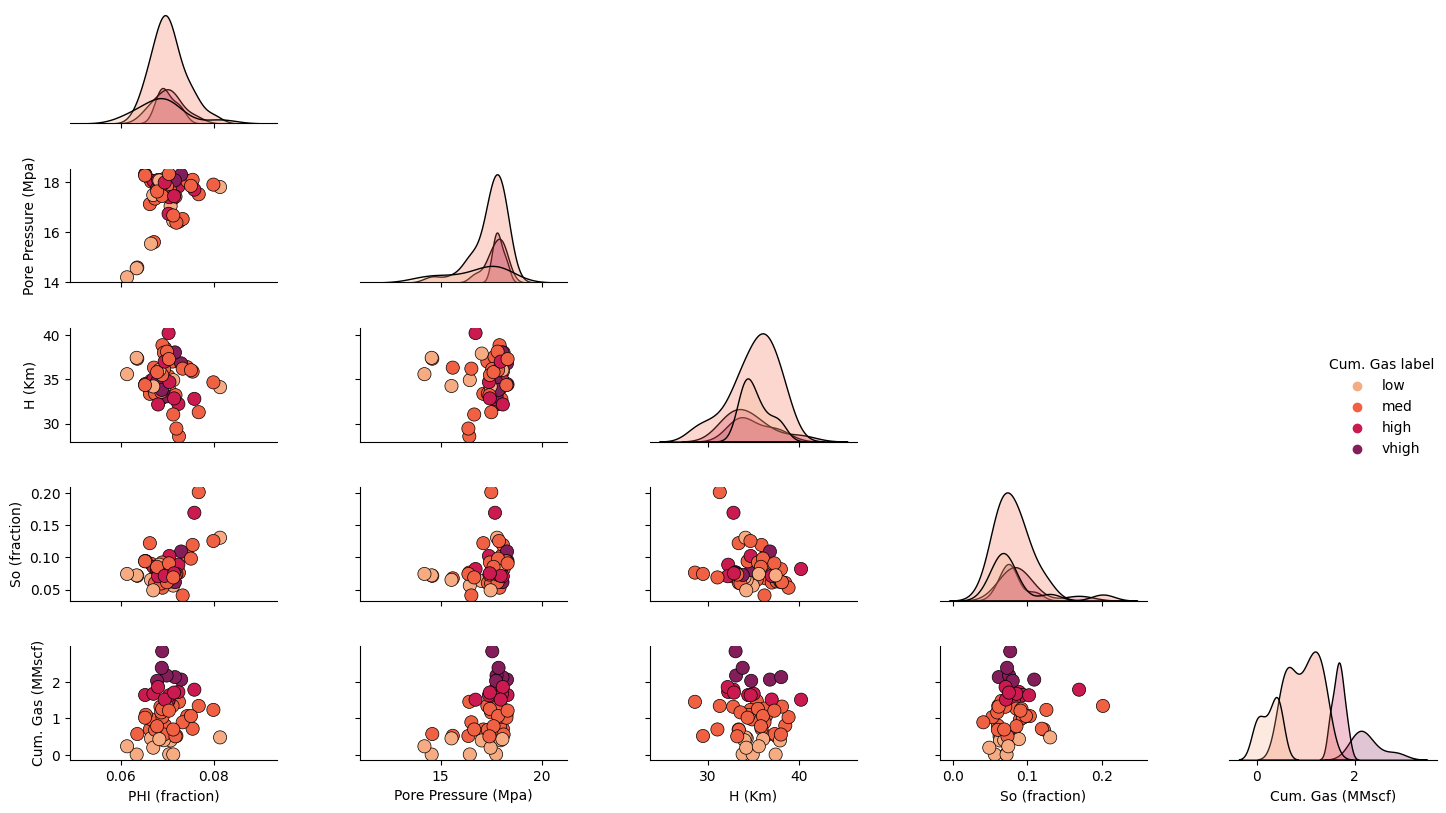

In [12]:
response = 'Cum. Gas label'
num_response = prodname
custom_bins = [0, 0.5, 1.5, 2.0, 2.9]

# Add category for response variable i.e., production levels for complete dataset
df = RT.make_levels(data=df, cat_response=response, num_response=num_response, custom_bins=custom_bins)
RT.matrix_scatter(df, [porname, presname, thickname, soname, prodname], 0., 0., 1., 0.6, 0.4, 0.4, 'Scatterplot of all features coded by production levels for entire dataset', 1, hue_=response, num_OOSP=None, n_case=True, save=True)

Prepare dataset and curate parameters/variables needed for N case and N+1 (OOSP) cases such that the OOSP's added are within 95% CI.

In [13]:
# Load used random nos for OOSP generation
path = "/Users/ademidemabadeje/Documents/UT/Research/PyCharm/LD_Stabilization/Fall 2022/Results/Results with new OOSP main script/Duvernay/N/"
prior_rand = np.load(path + "Random seed array for OOSP.npy", allow_pickle=True)
rand = list(prior_rand.item())[0]


# N case
N = len(df)
num_OOSP = 1
df_subset = df.iloc[:N,1:-1]

# N+1 i.e., OOSP case.
df_subset2, random_seeds_used = RT.make_sample_within_ci(df_subset.copy(), num_OOSP=num_OOSP, random_state=rand) # use this if importing the random seed array from file

#df_subset2, random_seeds_used = RT.make_sample_within_ci(df_subset.copy(), num_OOSP=num_OOSP) # use this to generate random OOSP, note that this will change everytime when run as it is randomly generated, which is saved to the variable "random_seeds_used" for use, so it can be tracked for reproduced

# save random seed used for OOSP generation
np.save('Random seed array for OOSP.npy', random_seeds_used)

# Insert well column index back into data frame for N+1 case
df_subset2.insert(0, 'Well', np.arange(1, len(df_subset2)+1))

# Insert well column index back into data frame for N case
df_subset.insert(0, 'Well', np.arange(1, len(df_subset)+1))

# Select predictor features of interest for proposed workflow
features = [porname, presname, thickname, soname]

#### Data Preparation

Make an ordinal feature from the continuous production:

1. low
2. medium
3. high
4. very high

production rates.  This will help visualize the results as we proceed, we can look at wells with different levels of production projected into a variety of lower dimensional spaces (LDS) with multidimensional scaling.

<br>

Let's start with the N-samples case

In [14]:
# Dataset for use in N case inclusive of category for response variable i.e., production levels
df_subset = RT.make_levels(data=df_subset, cat_response=response, num_response=num_response, custom_bins=custom_bins)
df_subset.head()

Well           X            Y  Pore Pressure (Mpa)     H (Km)  \
0     1  256.818665  6072.238414            15.595800  36.322800   
1     2  262.522883  6063.768151            16.414499  28.556400   
2     3  273.711783  6063.267474            17.809000  32.216599   
3     4  283.769714  6105.233958            17.500999  31.287800   
4     5  267.388443  6097.573707            17.108200  33.366402   

   PHI (fraction)  So (fraction)  Cum. Gas (MMscf) Cum. Gas label  
0        0.067142       0.067404          0.520823            med  
1        0.072521       0.076301          1.450993            med  
2        0.072394       0.088561          1.721126           high  
3        0.076772       0.201194          1.337968            med  
4        0.066267       0.121996          0.693374            med

Take a look at the matrix scatter plot of our 4 predictor features and the production levels for N case samples

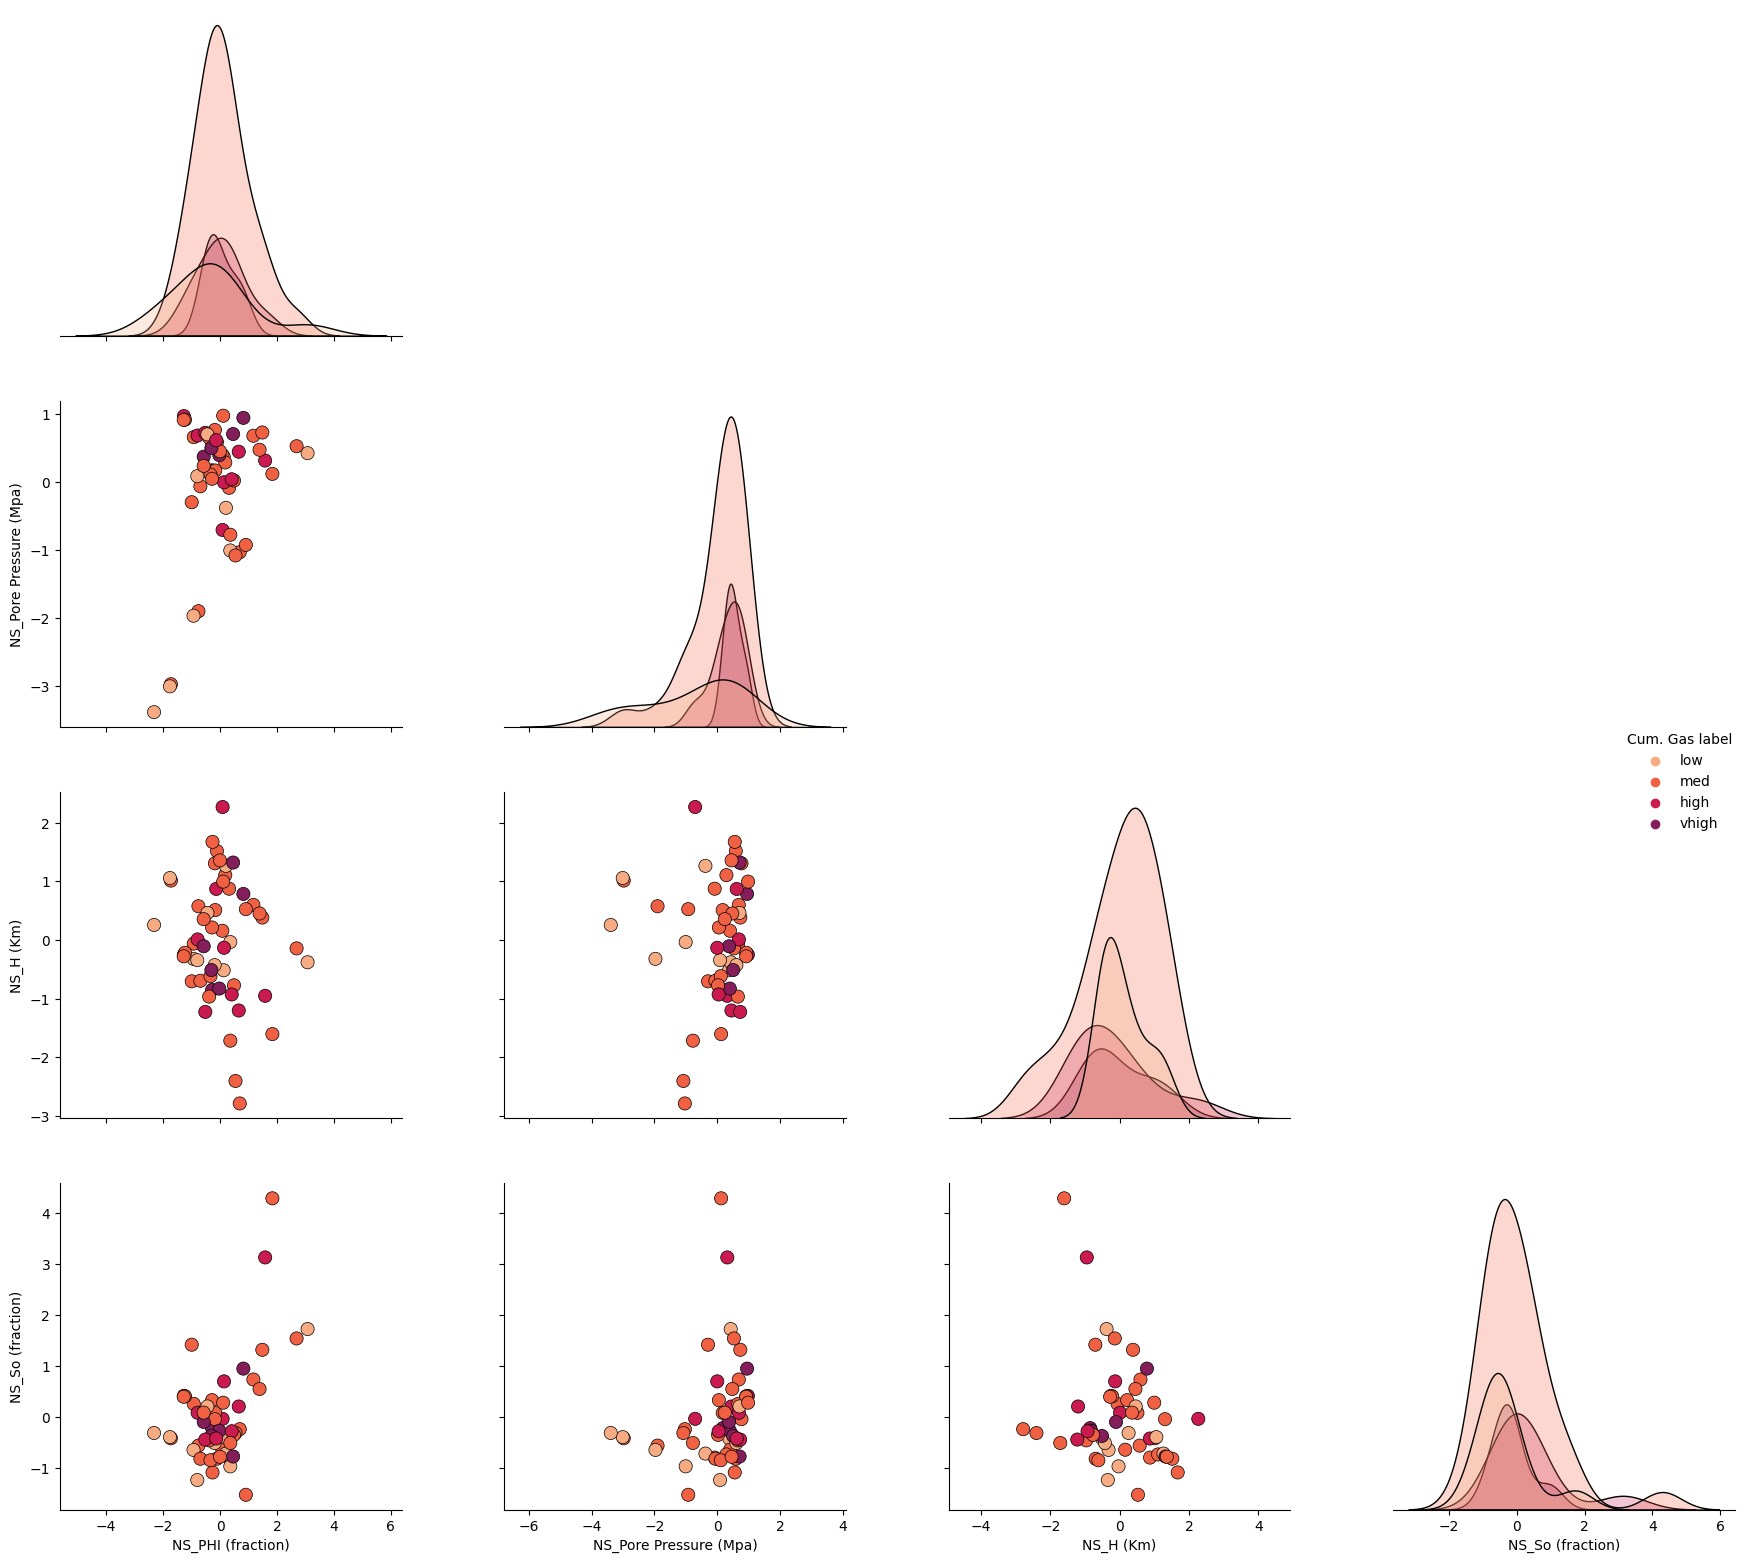

In [15]:
# Visualize the N-case dataset standardized

other_df = RT.standardizer(df_subset, features, keep_only_std_features=False)

# Visualize the matrix scatter plot of the 3 standardized features and the response i.e., production levels.
RT.matrix_scatter(other_df, ['NS_' + porname, 'NS_' + presname, 'NS_' + thickname, 'NS_' + soname], 0.0, 0.0, 1.5, 1.5, 0.3, 0.2, 'Scatterplot of standardized features colored by production levels for N case samples', 1, hue_=response, num_OOSP=None, n_case=True)

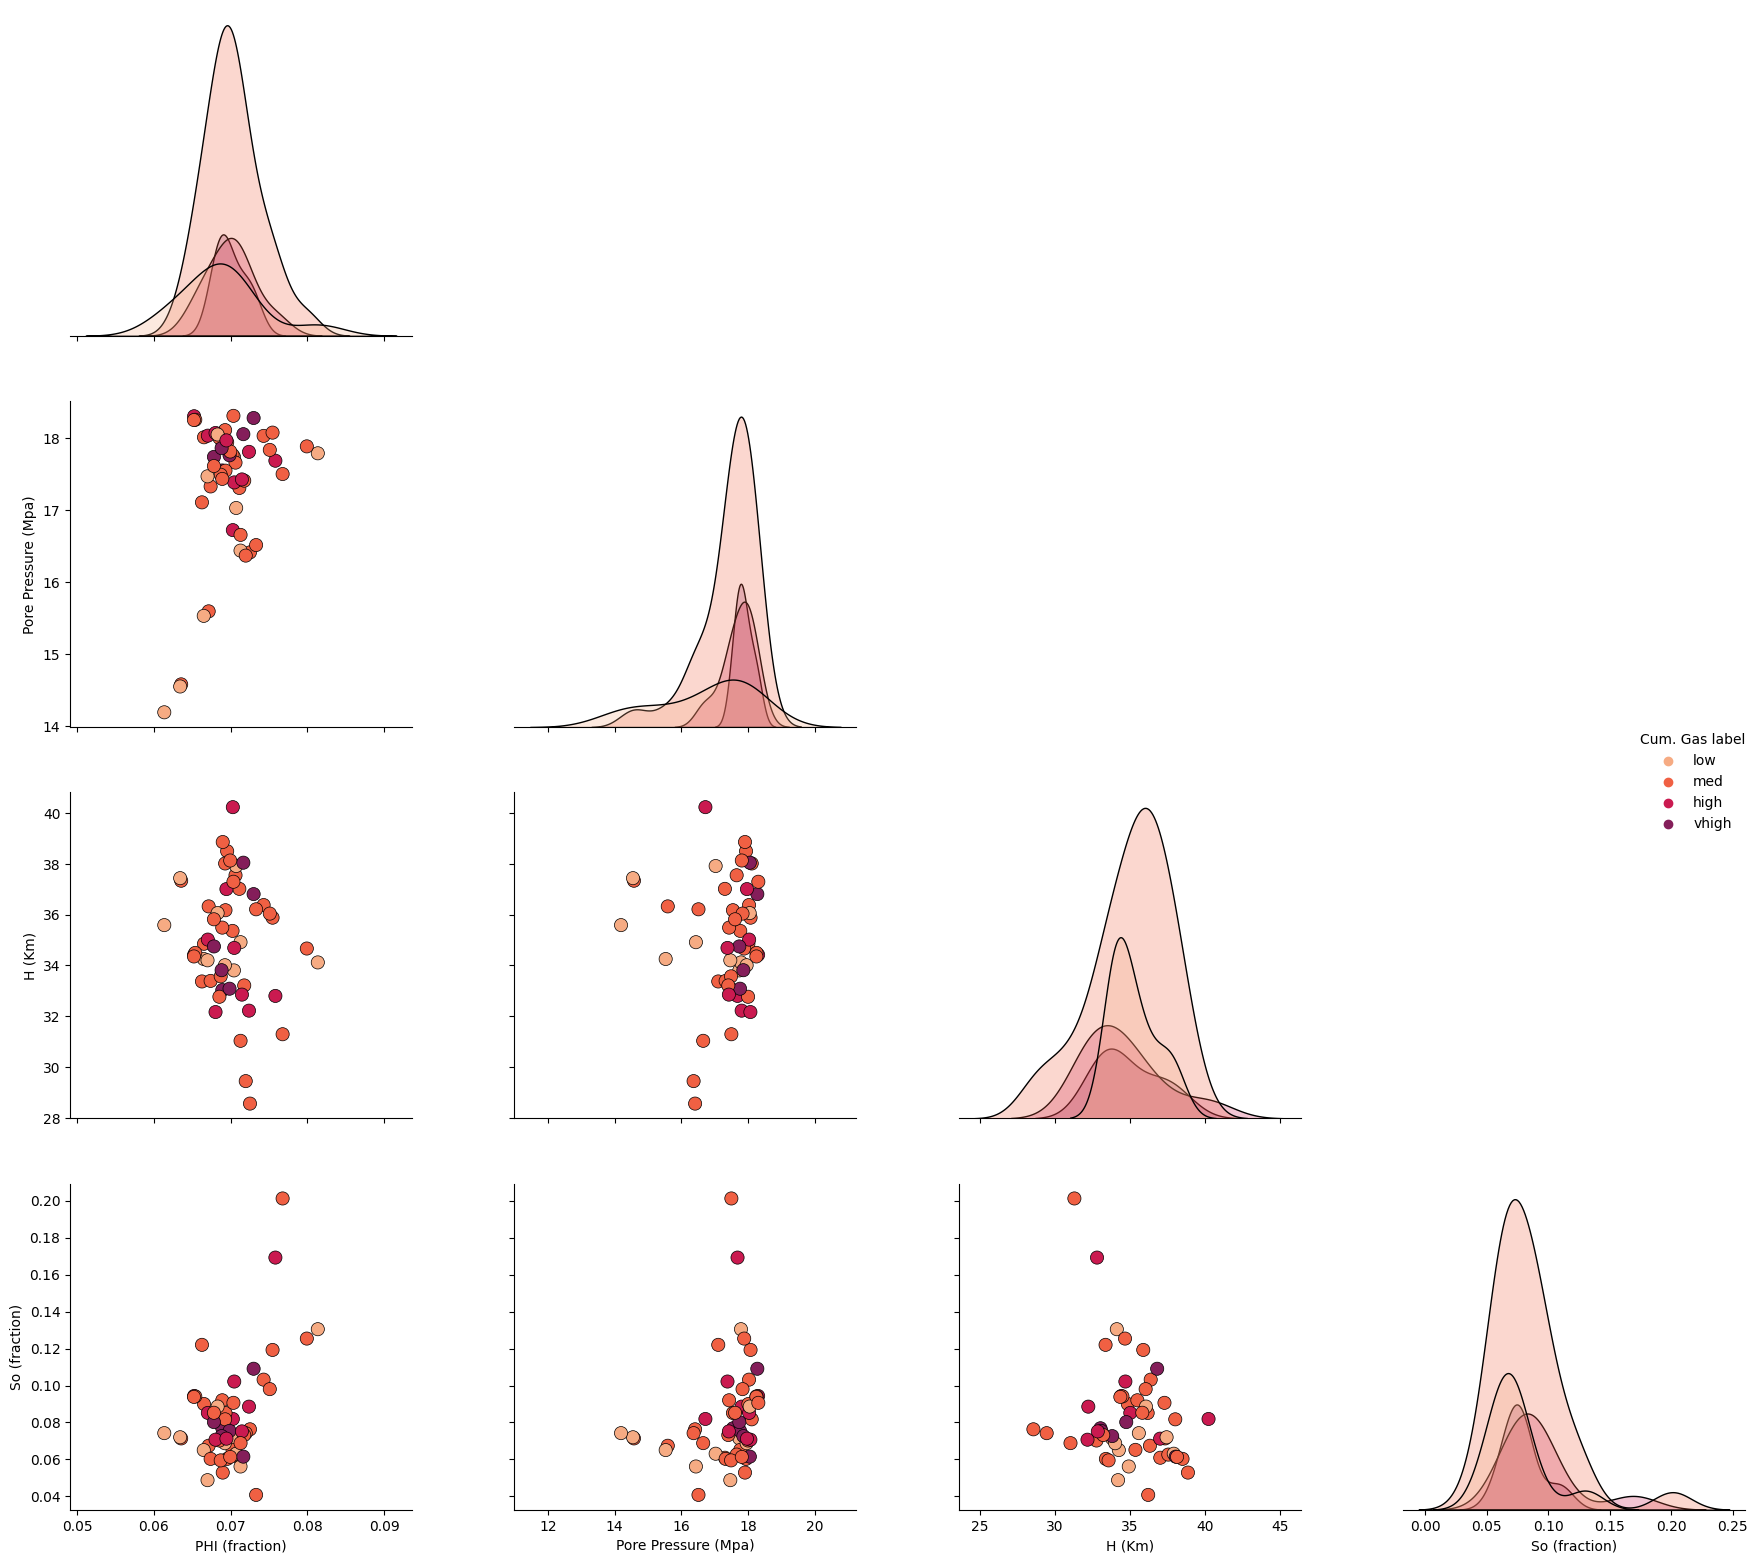

In [16]:
# Visualize the N-case dataset in original feature space

# Visualize the matrix scatter plot of the 4 features chosen and the response i.e., production levels in the original space.
RT.matrix_scatter(other_df, [porname, presname, thickname, soname], 0.0, 0.0, 1.5, 1.5, 0.3, 0.2,
                  'Scatterplot of features colored by production levels for N case samples', 1, hue_=response, num_OOSP=None, n_case=True)

Similarly, let's visualize the N+1 samples case with OOSP's.

In [17]:
# Dataset for use in N+1 case inclusive of category for response variable i.e., production levels
df_subset2 = RT.make_levels(data=df_subset2, cat_response=response, num_response=num_response, custom_bins=custom_bins)

Look at the matrix scatter plot of our 4 features and the production levels for N+1 case samples with OOSP.

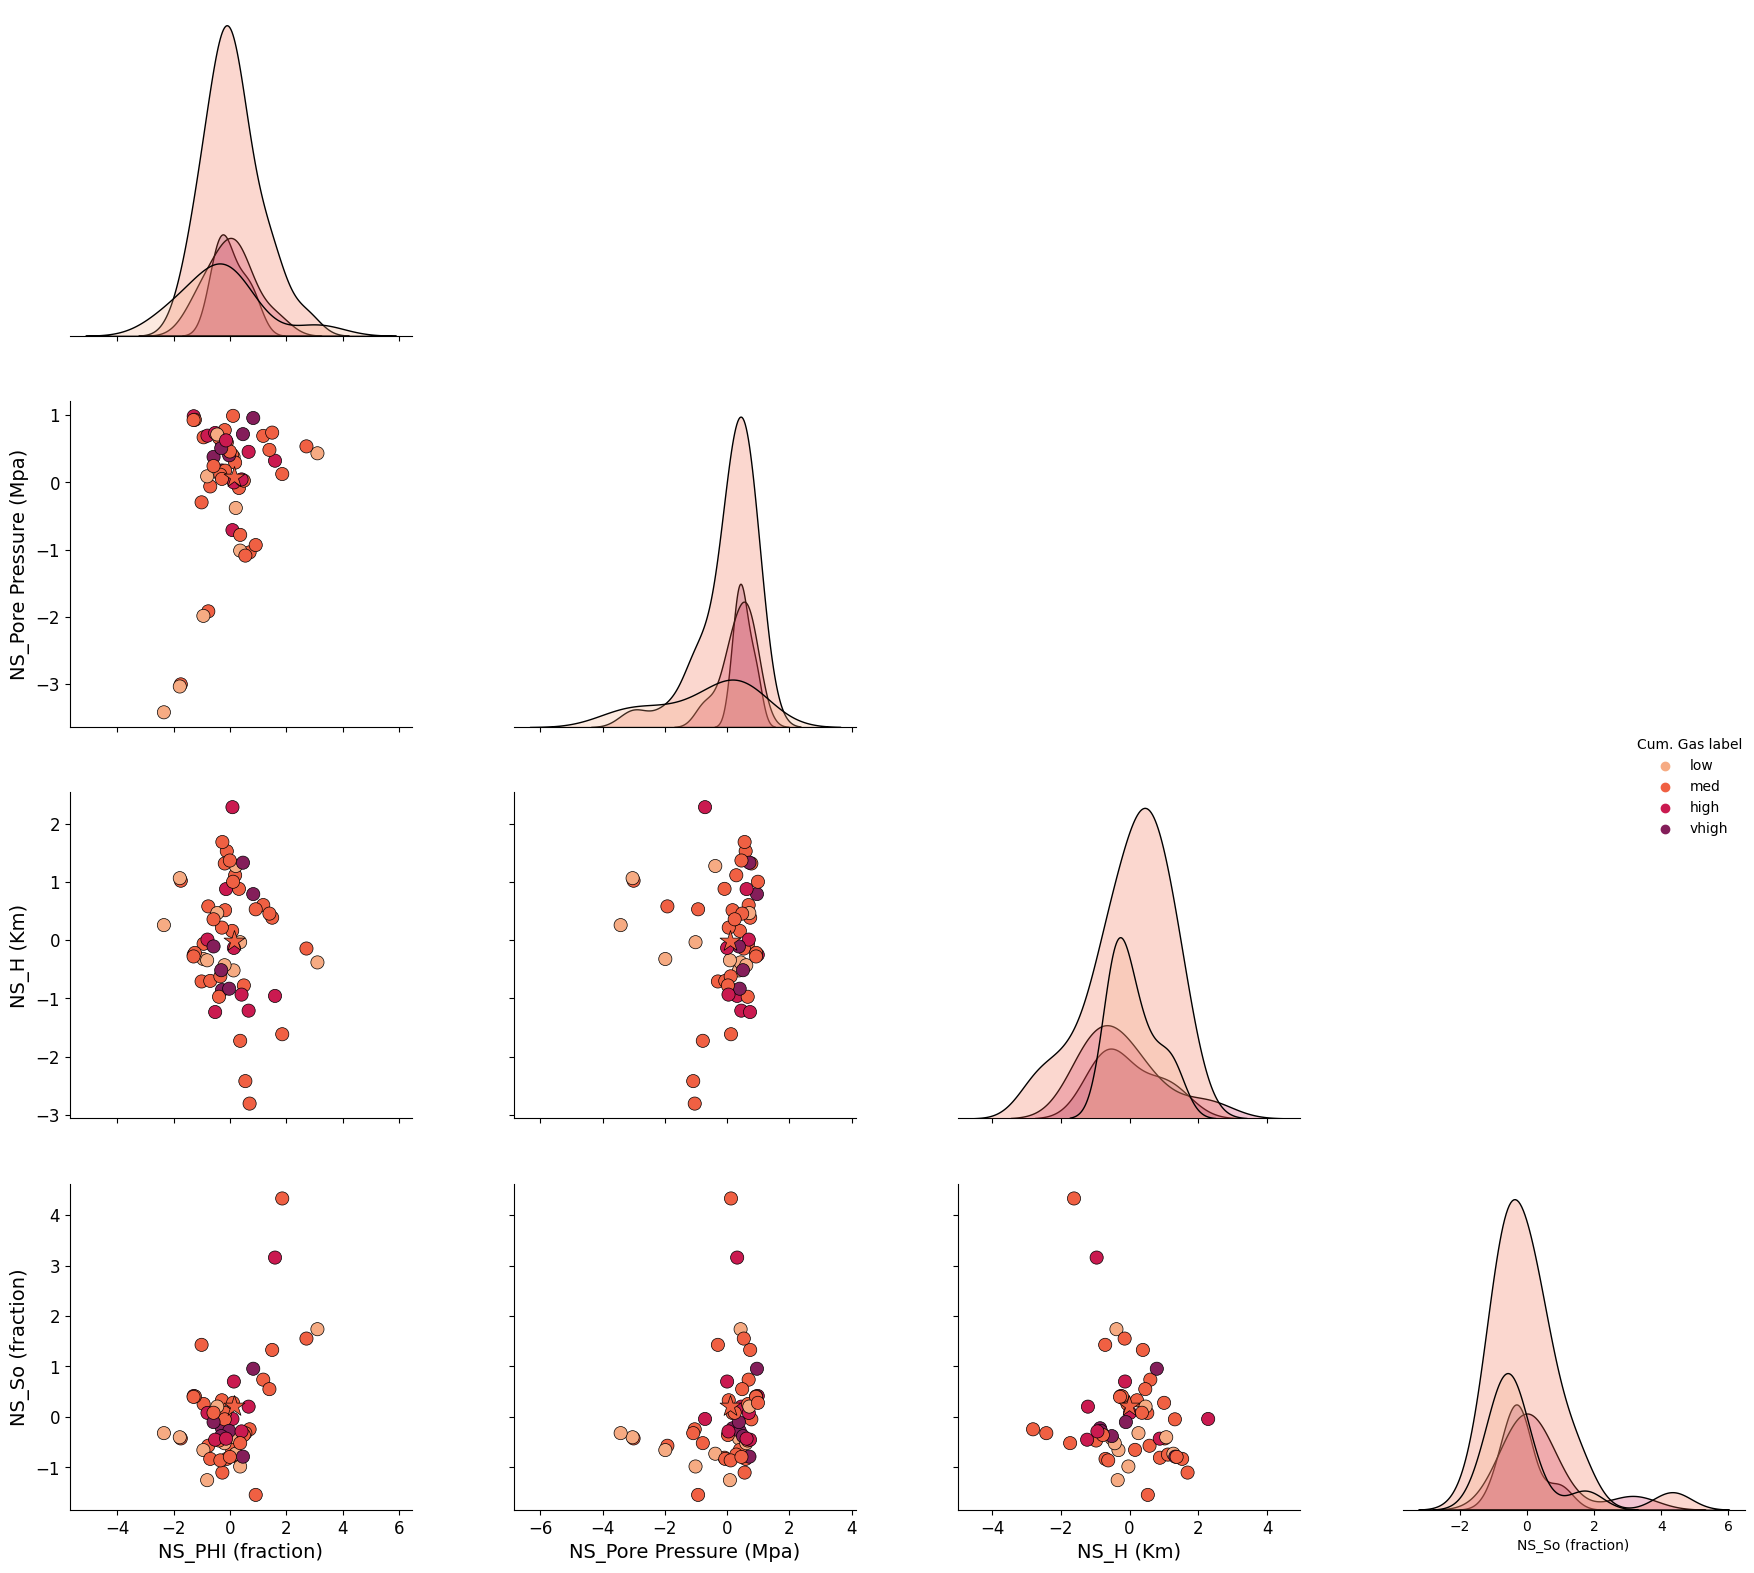

In [18]:
# Visualize the N+1 case dataset standardized

other_df = RT.standardizer(df_subset2, features, keep_only_std_features=False)

# Visualize the matrix scatter plot of the 3 standardized features and the response i.e., production levels.

RT.matrix_scatter(other_df, ['NS_' + porname, 'NS_' + presname, 'NS_' + thickname, 'NS_' + soname], 0.0, 0.0, 1.5, 1.5, 0.3, 0.2, 'Scatterplot of standardized features colored by production levels for N+1 case samples', 1, hue_=response, num_OOSP=num_OOSP, n_case=False, save=True)

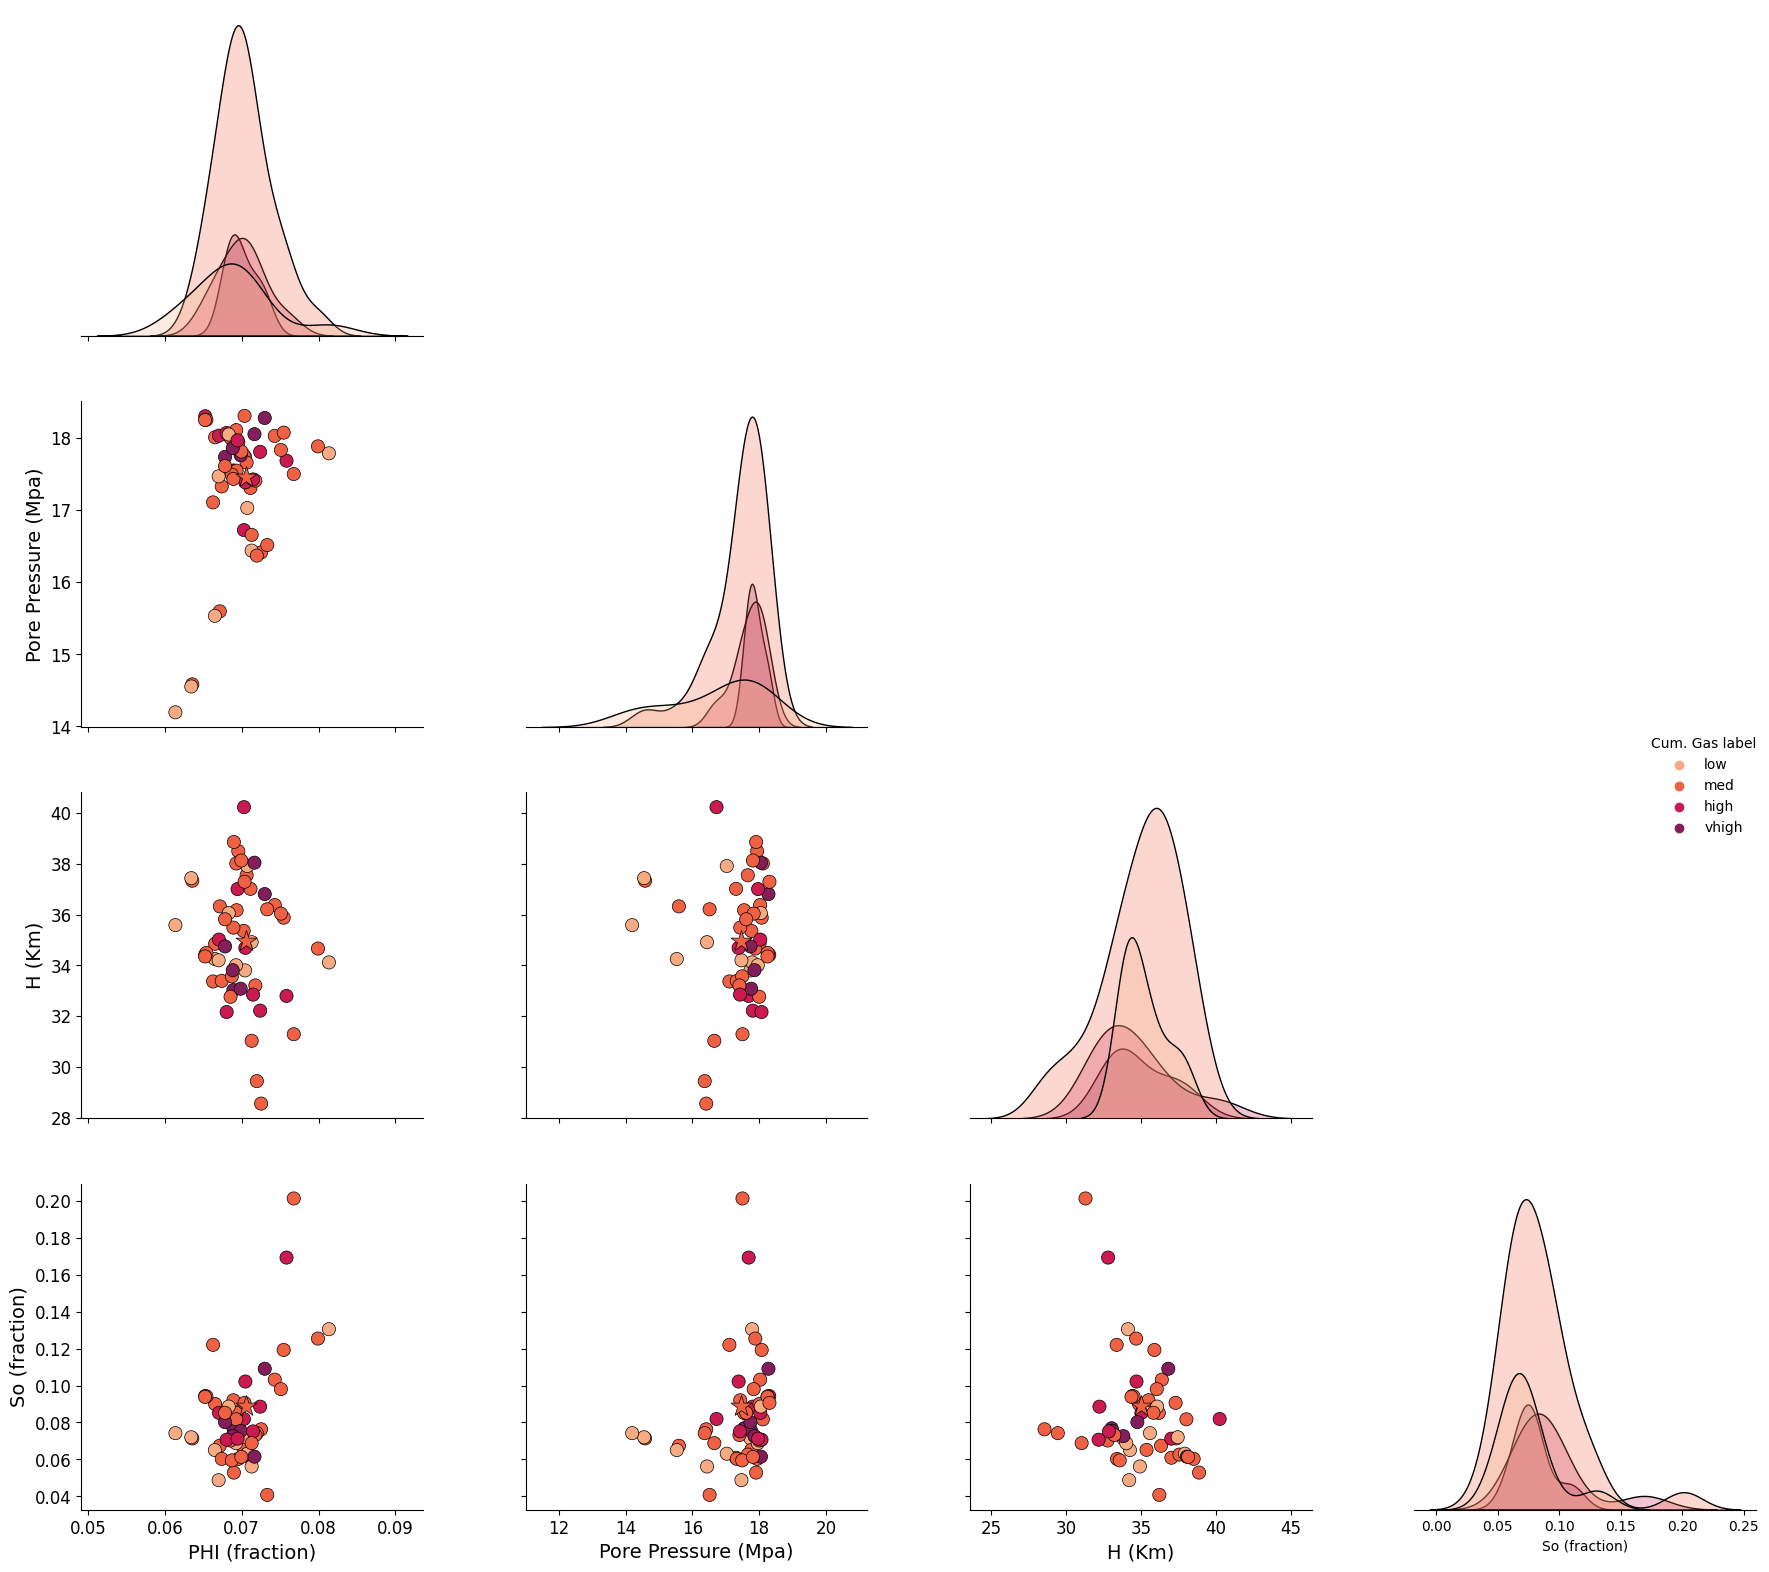

In [19]:
# Visualize the N+1 case dataset in original feature space

# Visualize the matrix scatter plot of the 3 standardized features and the response i.e., production levels.

RT.matrix_scatter(other_df, [porname, presname, thickname, soname], 0.0, 0.0, 1.5, 1.5, 0.3, 0.2,
                  'Scatterplot of features colored by production levels for N+1 case samples', 1, hue_=response, num_OOSP=num_OOSP, n_case=False, save=True)

# r'NS_AI  ($\mathrm{kg \, m^2/s}$)' for label in latex

# Workflow Application

## Section 1: N-case samples

Take the entire dataset, then instantiate the class. Do note that standardization and tabular outlier detection is performed on the features under the hood, this is imperative as our model works with dissimilarity-based distance metric.

In [20]:
# Curate parameters and variables
num_realizations = 100
base_seed = 42
start_seed = 1
stop_seed = 10000
idx = 'Well'
dissimilarity_metric="mahalanobis"
make_figure = True
dim_projection = '2d' # since the projection (p), is to 2 features. Use '3d' if the projection is to 3 features
normalize_projections = False

# Instantiate the class
obj = RT.RigidTransformation(df=df_subset, features=features, num_OOSP=num_OOSP, idx=idx, num_realizations=num_realizations, base_seed=base_seed, start_seed=start_seed, stop_seed=stop_seed, dissimilarity_metric=dissimilarity_metric, dim_projection=dim_projection, custom_dij=None)

# Run rigid MDS
random_seeds, all_real, calc_real, all_rmse, norm_stress = obj.run_rigid_MDS(normalize_projections=normalize_projections)

Visualize the base case and three example realizations to highlight difference in LDS obtained

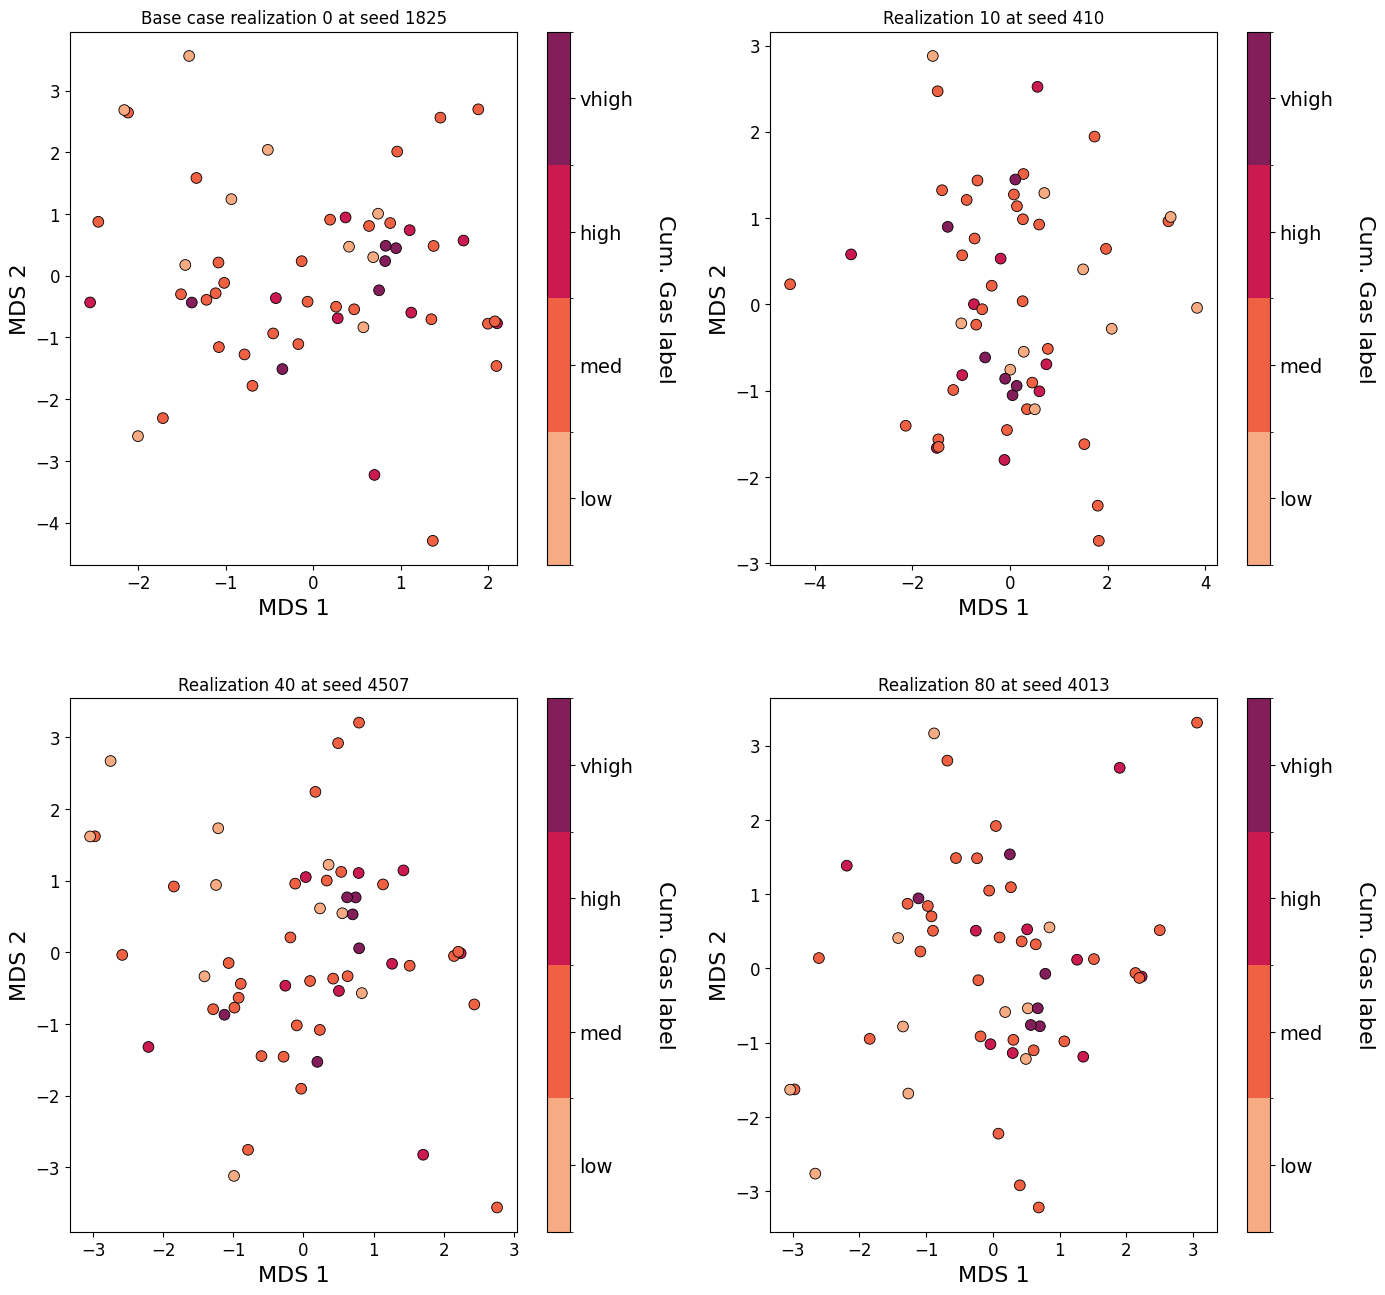

In [21]:
r_list=[0, 10, 40, 80]
Ax='MDS 1'
Ay='MDS 2'
title=['Base case realization ', 'Realization ', 'Realization ', 'Realization ']
x_off=0.02
y_off=0.07

#Set color map criteria
dpalette = sns.color_palette("rocket_r",n_colors = len(df_subset[response].unique()) + 1)
cmap=dpalette

obj.real_plotter(response=response, r_idx=r_list, Ax=Ax, Ay=Ay , title=title, x_off=x_off, y_off=y_off,cmap=dpalette, annotate=False, n_case=True, array2=None, save=True)

Prior to stabilization of data points, visualize all realizations on the same plot to show MDS is not rotation invariant.

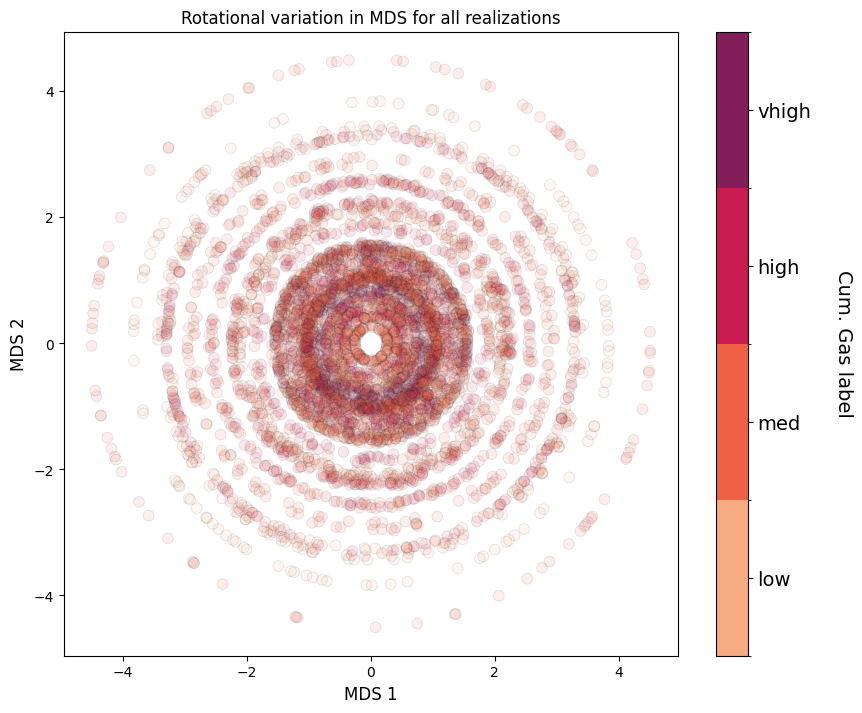

In [22]:
obj.bivariate_plotter(palette_=1, response=response, x_off=x_off, y_off=y_off, title='Rotational variation in MDS for all realizations',
                     plot_type='variation', Ax=Ax, Ay=Ay, annotate=False, save=True)

Visualize the base case and the corresponding stabilized solution for previously chosen example realizations.

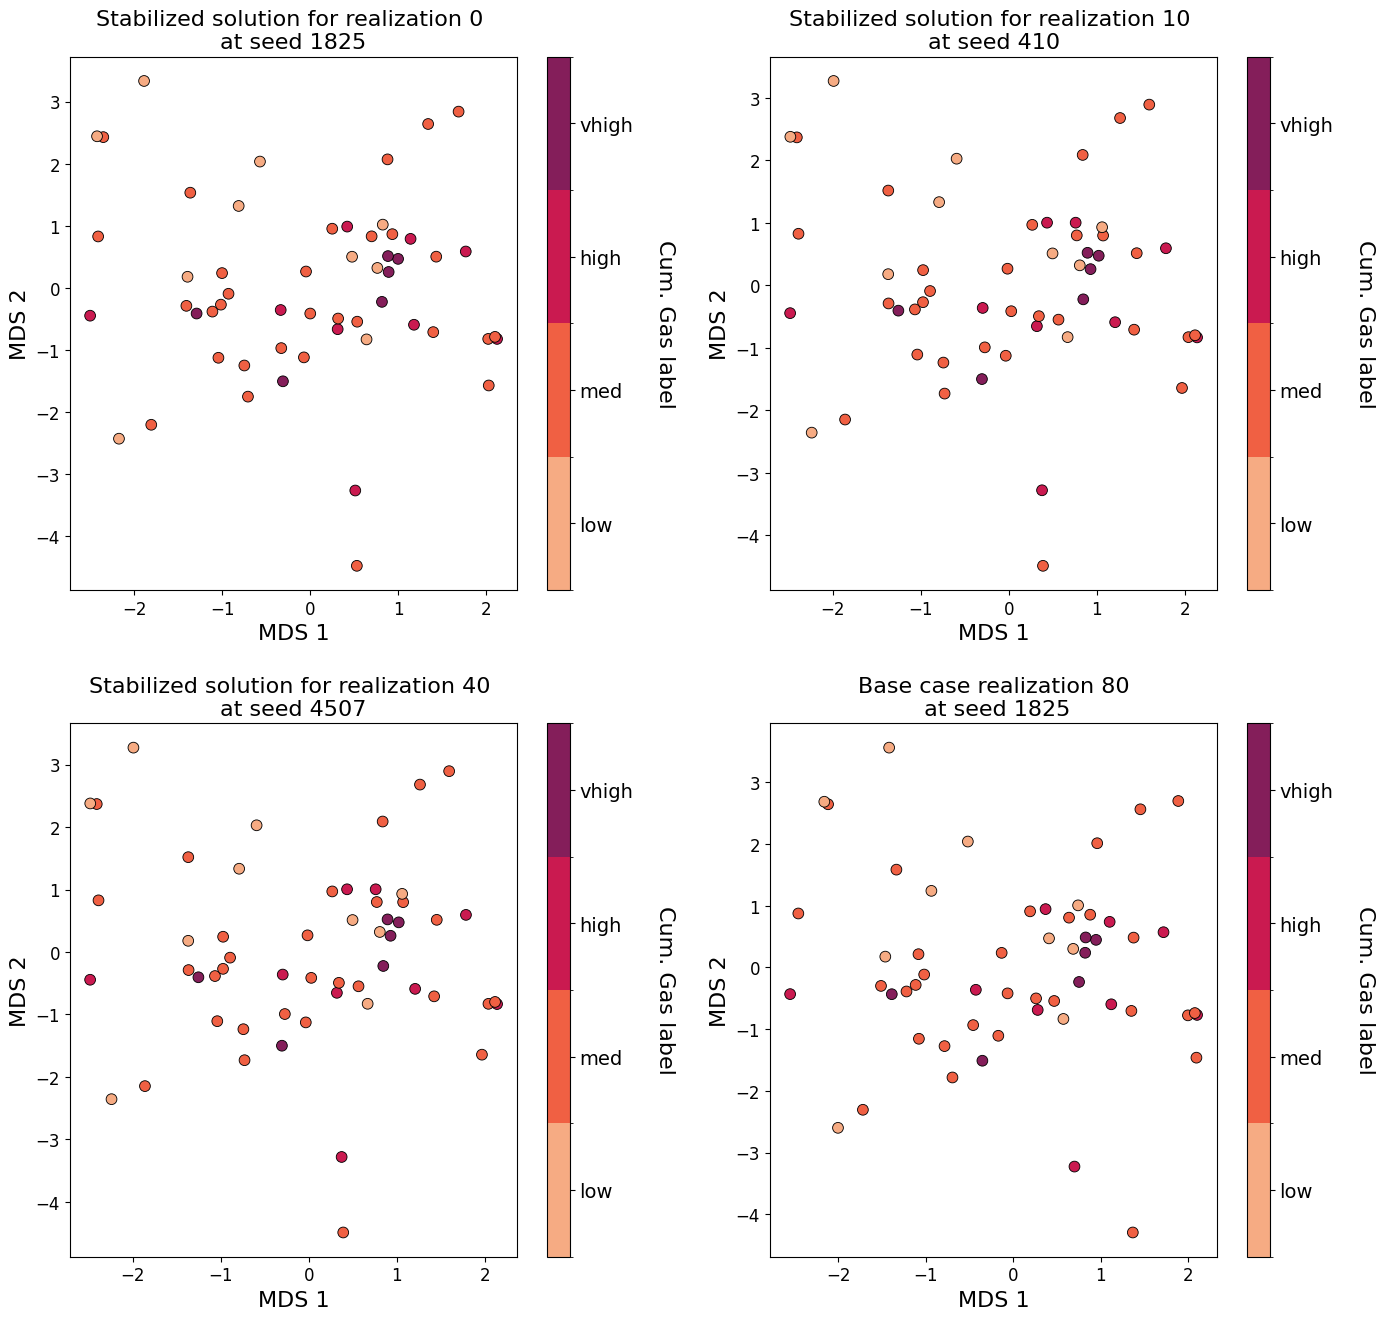

In [23]:
obj.real_plotter(response=response, r_idx=r_list, Ax=Ax, Ay=Ay , title=title, x_off=x_off, y_off=y_off, annotate=False, cmap=dpalette, array2=calc_real, n_case=True, save=True)

The realization examples are perfectly transformed to match the base case although slight distortion is seen in the base case even though all sample points are registered correctly.


Next, visualize the 2D registration jitters in the newly found stabilized solutions.

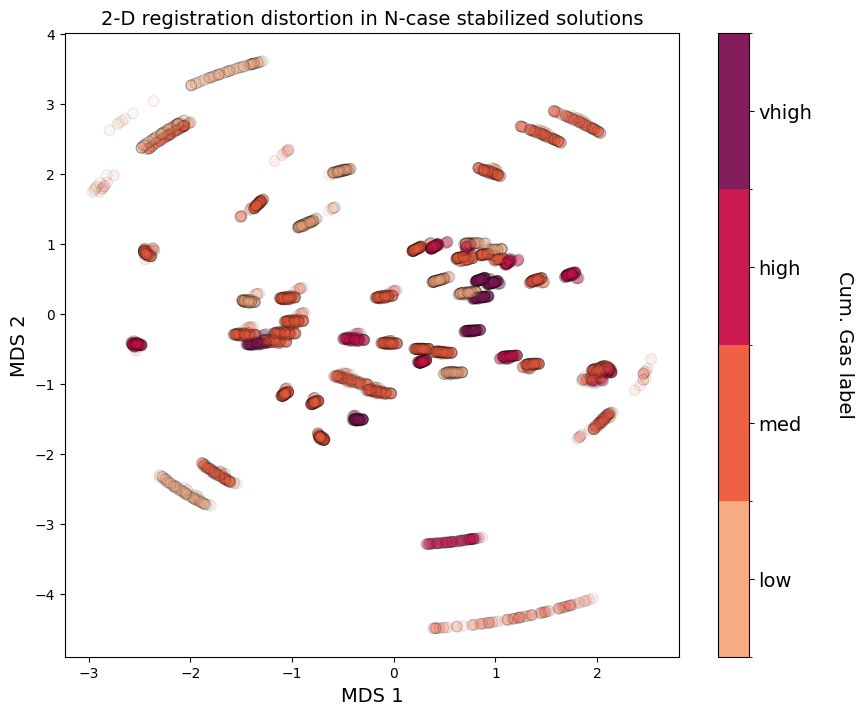

In [24]:
obj.bivariate_plotter(palette_=1, response=response, x_off=x_off, y_off=y_off, title='2-D registration distortion in N-case stabilized solutions',
                         plot_type='jitters', Ax=Ax, Ay=Ay, annotate=False, save=True)

We see the distortions albeit not yet quantified for each sample in the dataset in the above figure, so we visualize the expectation of these stabilized solutions.

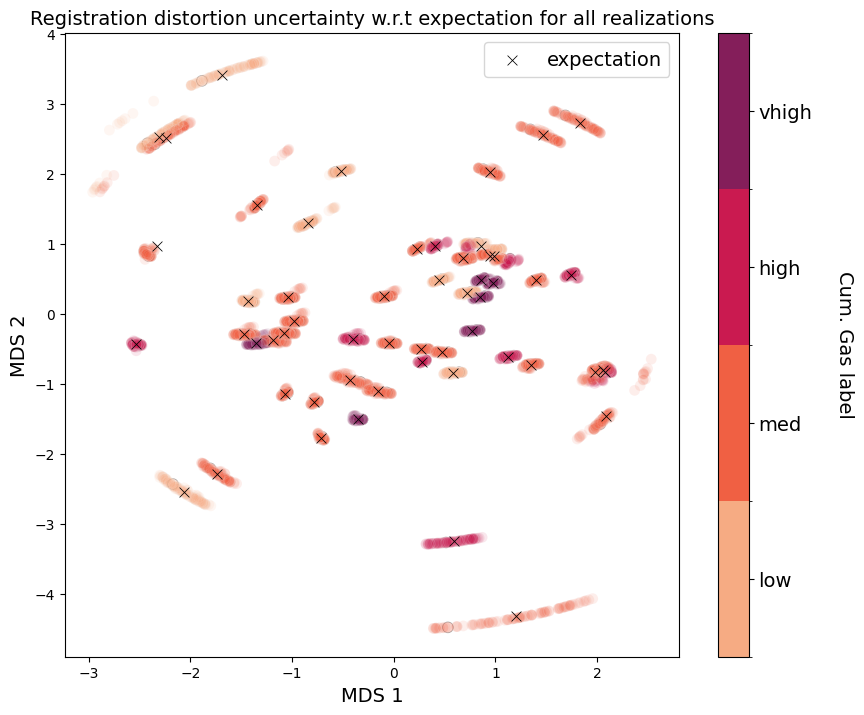

In [25]:
obj.bivariate_plotter(palette_=1, response=response, x_off=x_off, y_off=y_off, title='Registration distortion uncertainty w.r.t expectation for all realizations',
                         plot_type='uncertainty', Ax=Ax, Ay=Ay, annotate=False, save=True)

Based on the scenarios above, we see that regardless of the seed or random state used when computing the MDS projections, similar stabilized solutions are obtained with distortions/jitters. Next, we average out the stabilized solutions obtained to get a more accurate location for the projections in the MDS space by obtaining the expectation of the ith sample over enough realizations as the ground truth projection coordinates.


Note that using the ensemble expectation of the stabilized solution helps removed effects from slight random offsets, perturbations, or distortions if any within the n-sample demonstration.

In [26]:
# Set base case index of choice
bc_idx =0


E = obj.expectation(r_idx=bc_idx, Ax=Ax, Ay=Ay, verbose=True)

The effective variance of the base case is 3.7793 with a MDS 1 variance of 1.6177 and MDS 2 variance of 2.1616
The effective variance of the expected stabilized solution is 3.7567 with a MDS 1 variance of 1.6268 and MDS 2 variance of 2.1299


Visualize the ensemble expectation of the stabilized MDS projections over multiple realizations compared to the base case.

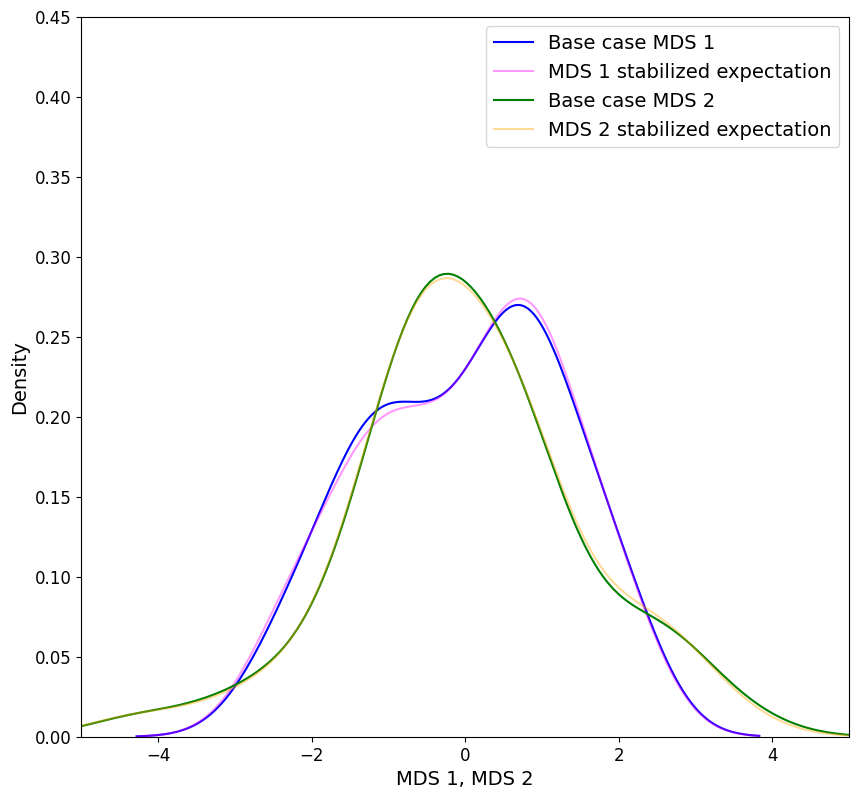

In [27]:
xmin = -5
xmax = 5
ymin = 0.0
ymax = 0.45

obj.expect_plotter(r_idx=bc_idx, Lx=Ax, Ly=Ay, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, save=True)

Visualize base case with ensemble expectation of the stabilized solution over all realizations for comparison for the N sample case.

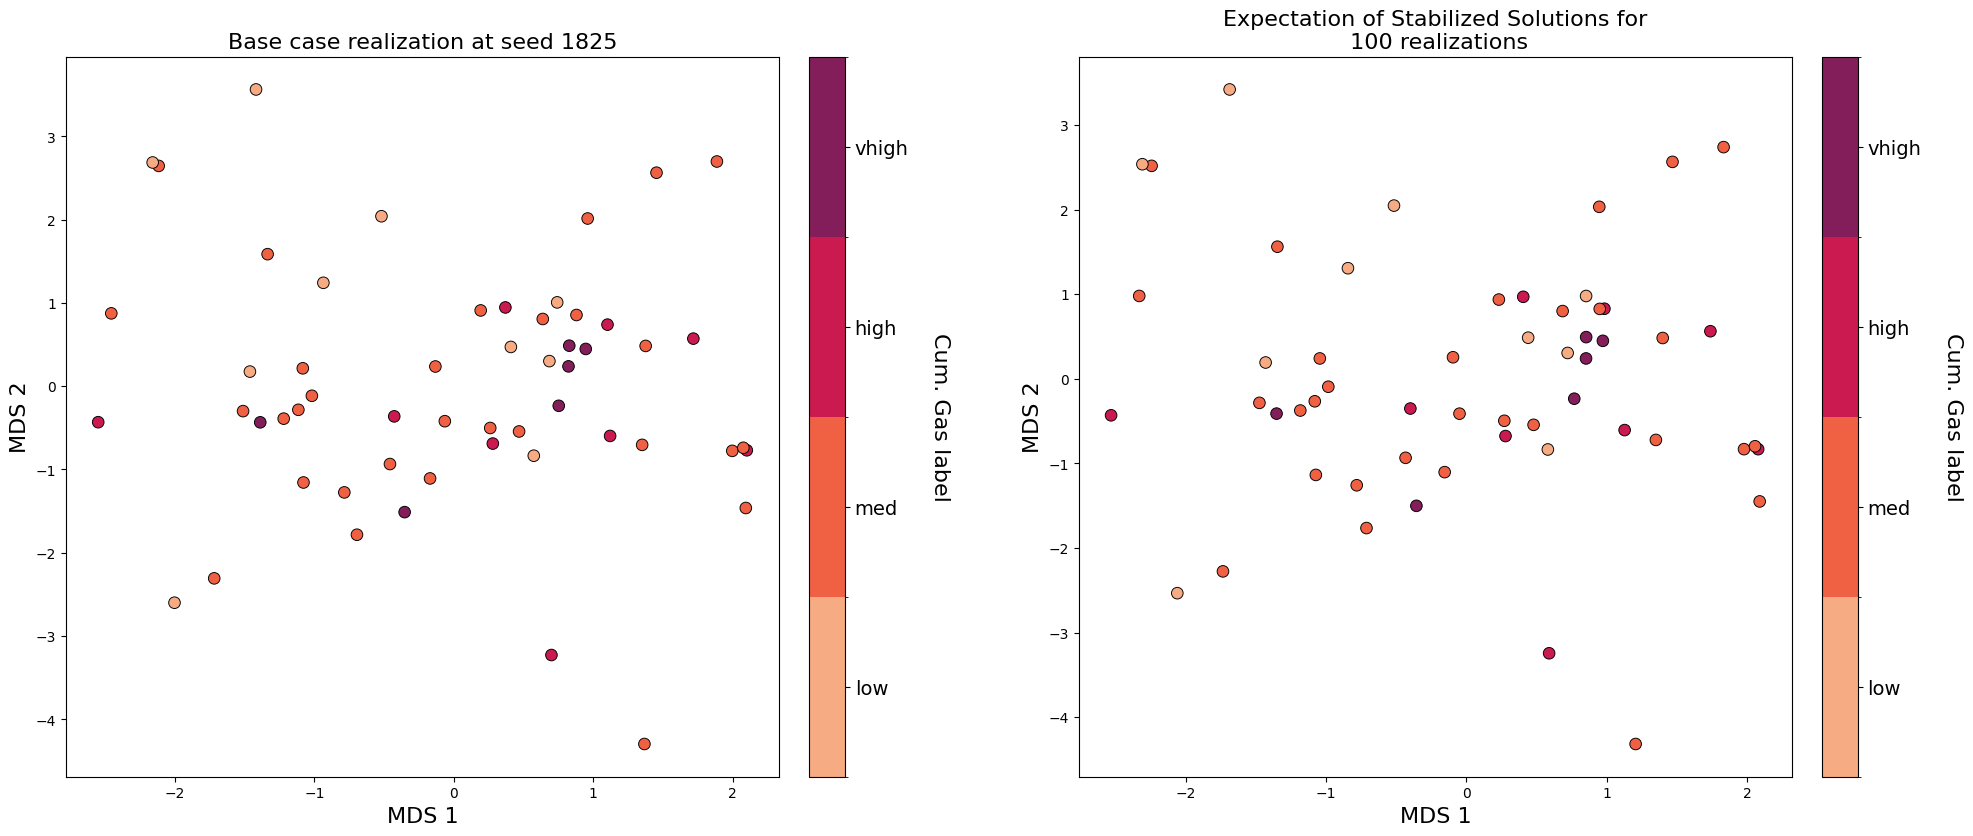

In [28]:
obj.compare_plot(response=response, r_idx=bc_idx, Ax=Ax, Ay=Ay, x_off=x_off, y_off=y_off, n_case=True, annotate=False, cmap=dpalette, save=True)

Let's check our model:

* we will calculate the original and projected pairwise distances between all the samples

* we will cross plot the original vs the projects pairwise distances

* we will plot the distribution of the ratio between projects / original pariwise distances

Now, let's calculate the distortion between original and projected pairwise distances between all samples.

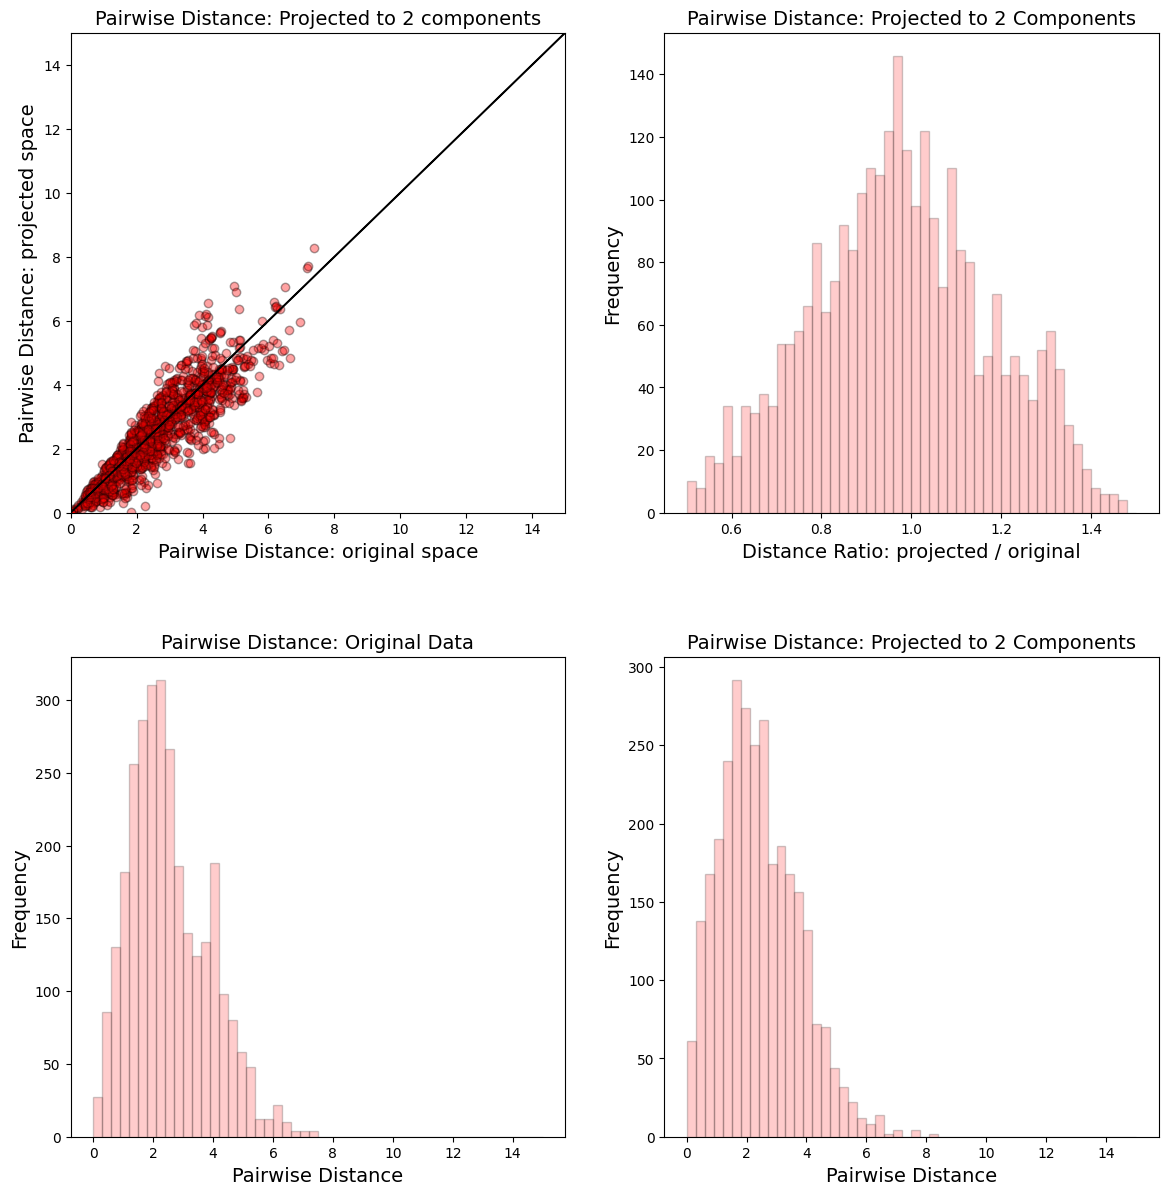

Distance Ratio, mean: 0.9535, standard deviation: 0.2407.


In [29]:
obj.visual_model_check(norm_type='L2', fig_name='Model check for N case samples', array=E, expectation_compute=True, save=True)

From the above, We projected to a 2 dimensional feature space and did a pretty good job preserving the pairwise distances between the samples.


Now, let's find the convex hull polygon and identify the anchor points for the n-case scenario in the lower dimensional space.

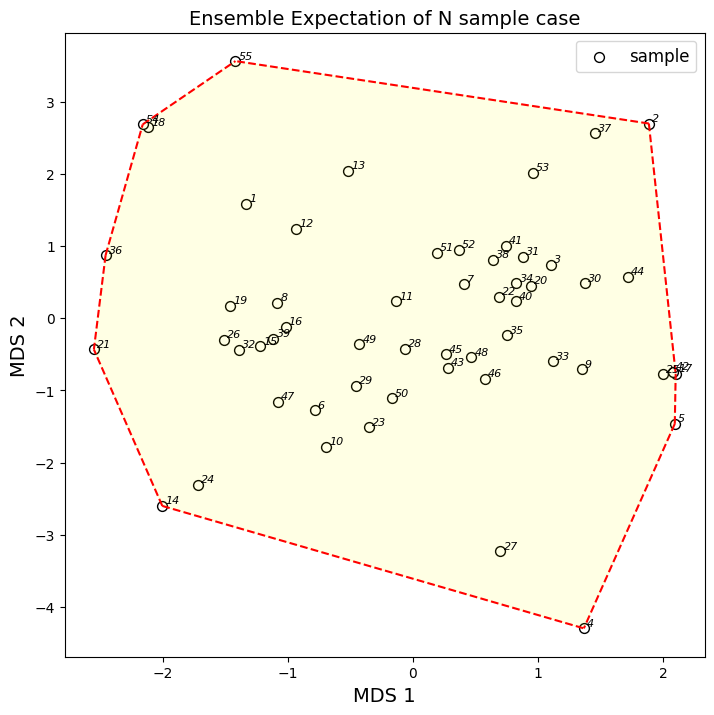

In [30]:
my_points, hull, vertices = obj.convex_hull(array=all_real, num_OOSP=None, title='Ensemble Expectation of N sample case', x_off=0.025, y_off=0.03, Ax=Ax, Ay=Ay, make_figure=make_figure, expectation_compute=False, save=True)

Visualize the marginal distributions for each predictor and threshold at which proposed methodology will work and/or fail. This is shown because if the OOSP is chosen from the tails, the vertices of the anchor set might change, making stabilization a non-trivial task.

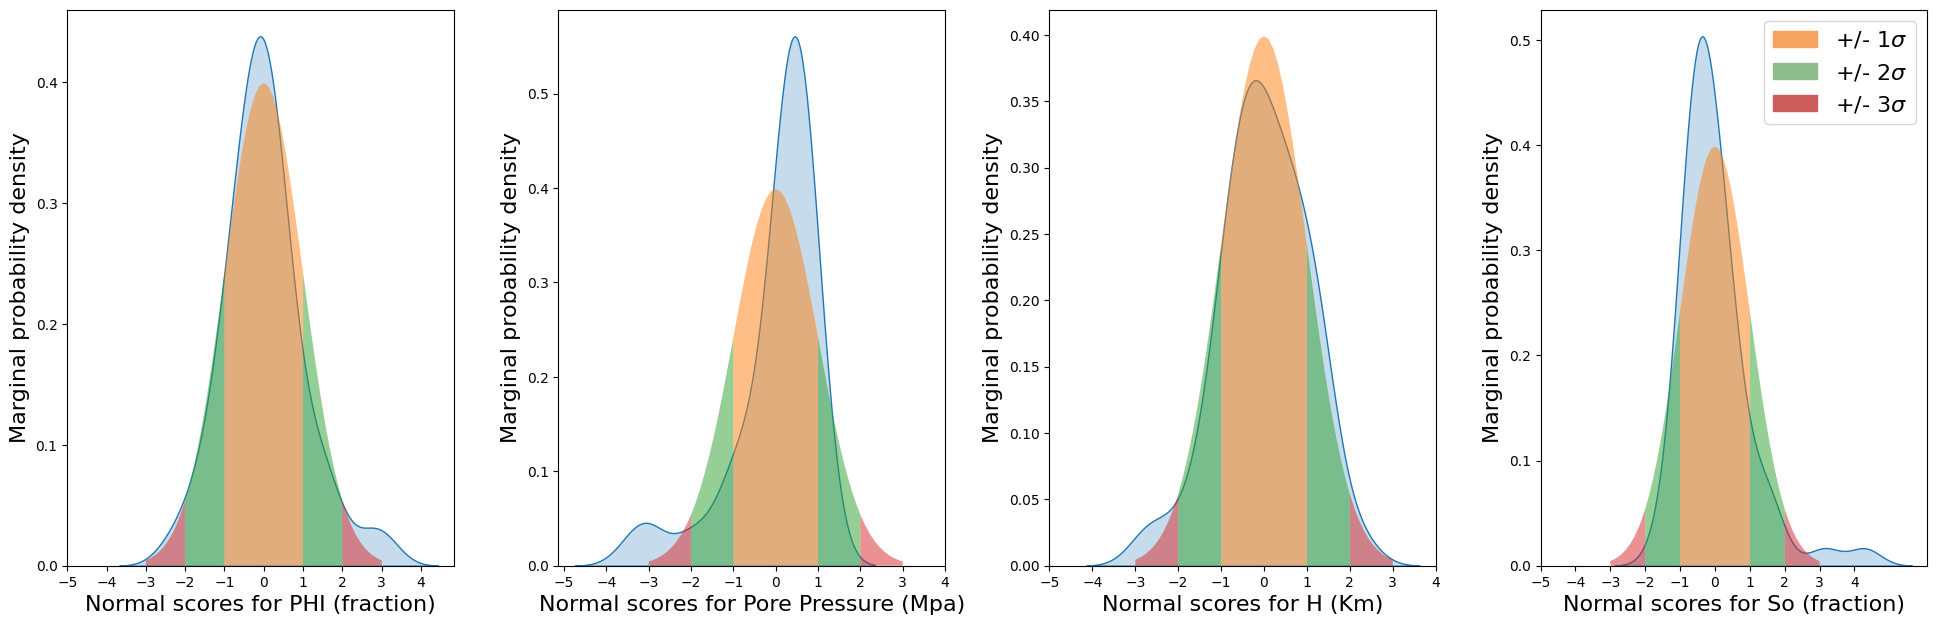

In [31]:
obj.marginal_dbn(save=True)


<br>

<br>



# Section 2:  For N + 1 Case with OOSP
<br>

Add OOSP to data and run.

In [32]:
# Instantiate the class
obj2 = RT.RigidTransf_NPlus(df=df_subset2, features=features, num_OOSP=num_OOSP, idx=idx, num_realizations=num_realizations, base_seed=base_seed, start_seed=start_seed, stop_seed=stop_seed, dissimilarity_metric=dissimilarity_metric, dim_projection=dim_projection, custom_dij=None)

In [33]:
# Run rigid MDS
random_seeds2, all_real2, calc_real2, all_rmse2, norm_stress2 = obj2.run_rigid_MDS(normalize_projections = normalize_projections)

Visualize base case and three example realizations in N+1 case with OOSP added.

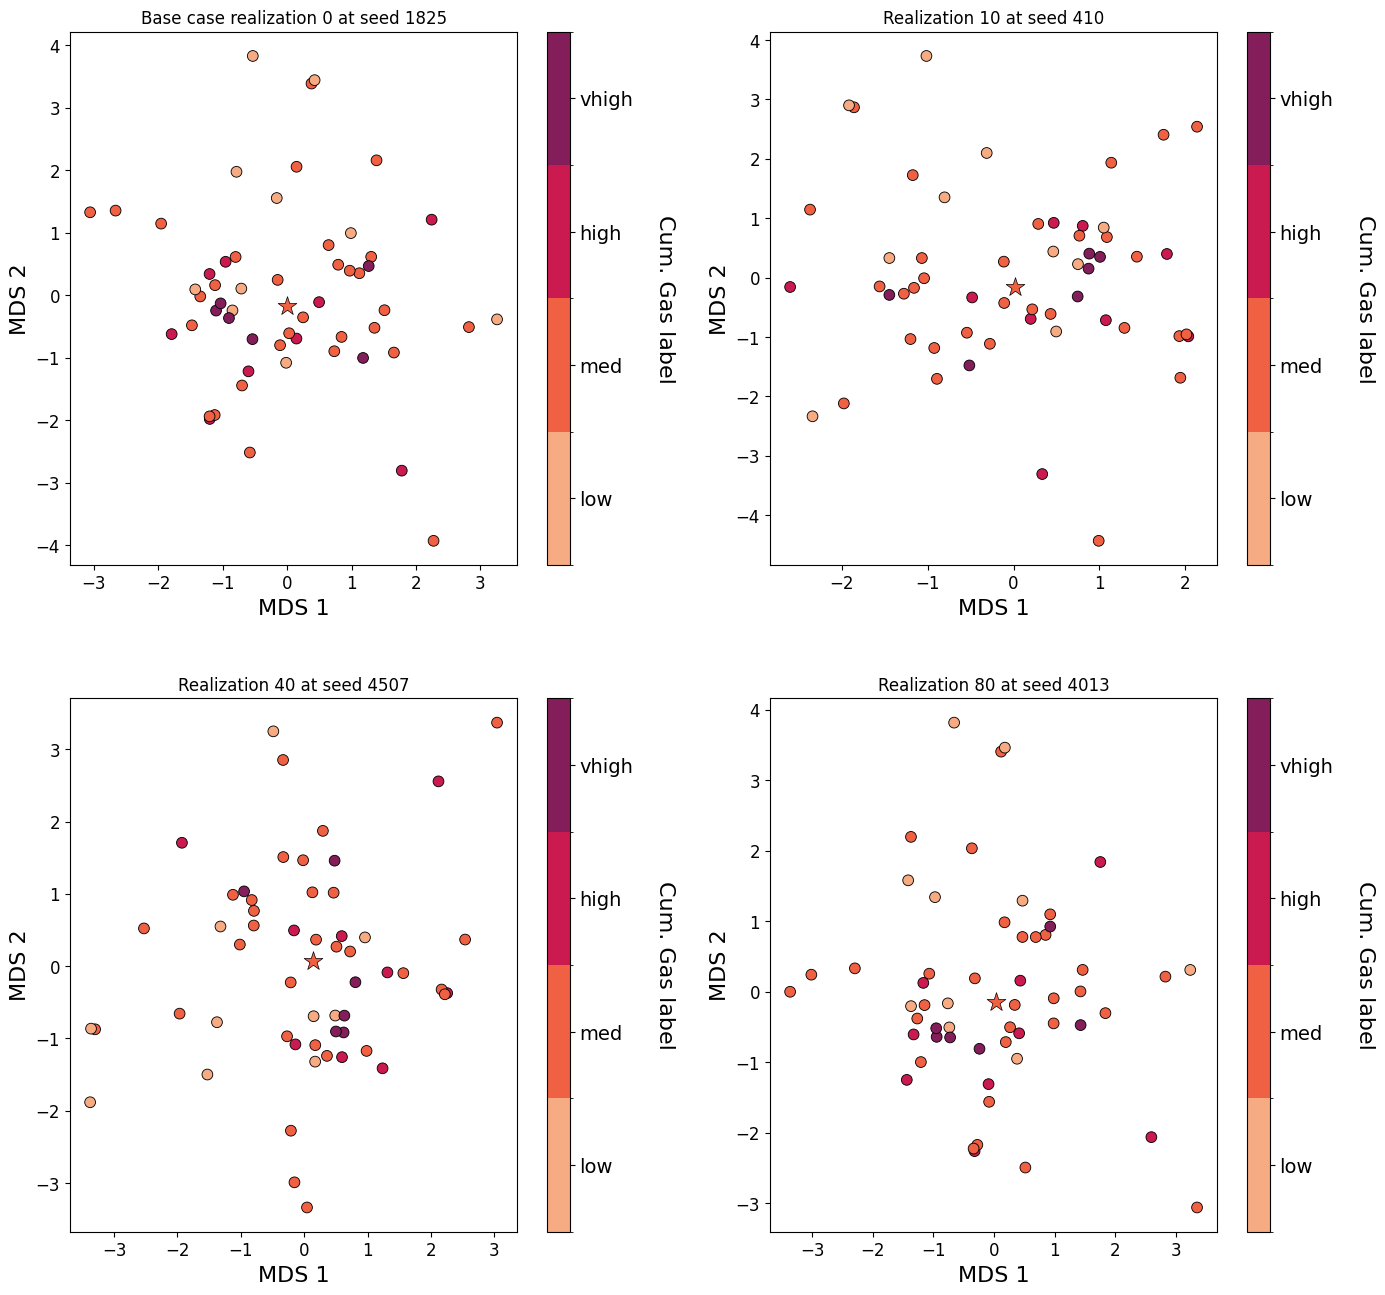

In [34]:
obj2.real_plotter(response=response, r_idx=r_list, Ax=Ax, Ay=Ay , title=title, x_off=x_off, y_off=y_off,cmap=dpalette, n_case=False, annotate=False, array2=None, save=True)

Visualize the base case and stabilized solution for prior example realizations with respect to the base case in N-sample case

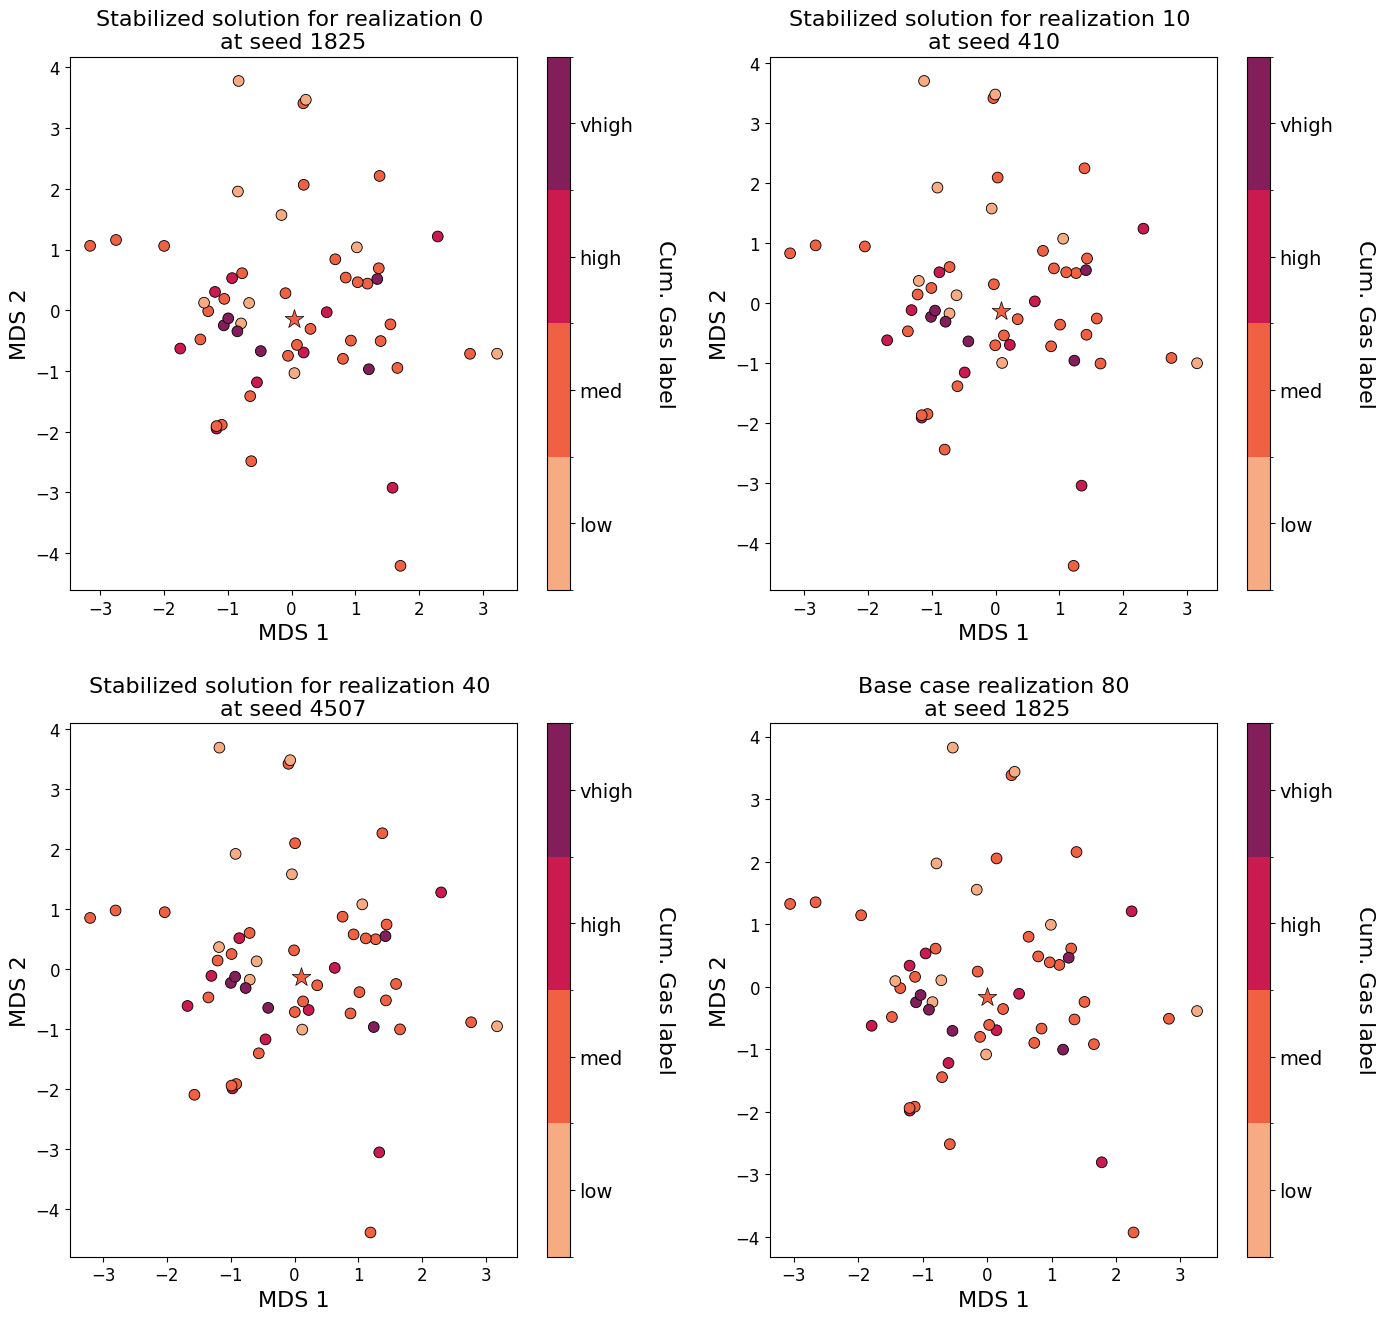

In [35]:
obj2.real_plotter(response=response, r_idx=r_list, Ax=Ax, Ay=Ay , title=title, x_off=x_off, y_off=y_off,cmap=dpalette, annotate=False,n_case=False, array2=calc_real2, save=True)

Since using the ensemble expectation of the stabilized solution helps remove effects from slight random offsets, perturbations, or distortions if any within the n+1-sample demonstration.

In [36]:
# Set base case index of choice for N+1 scenario
bc_idx =0 # new_idx


E2 = obj2.expectation(r_idx=bc_idx, Ax=Ax, Ay=Ay, verbose=True)

The effective variance of the base case is 3.7814 with a MDS 1 variance of 1.7158 and MDS 2 variance of 2.0656
The effective variance of the expected stabilized solution is 3.694 with a MDS 1 variance of 1.658 and MDS 2 variance of 2.0361


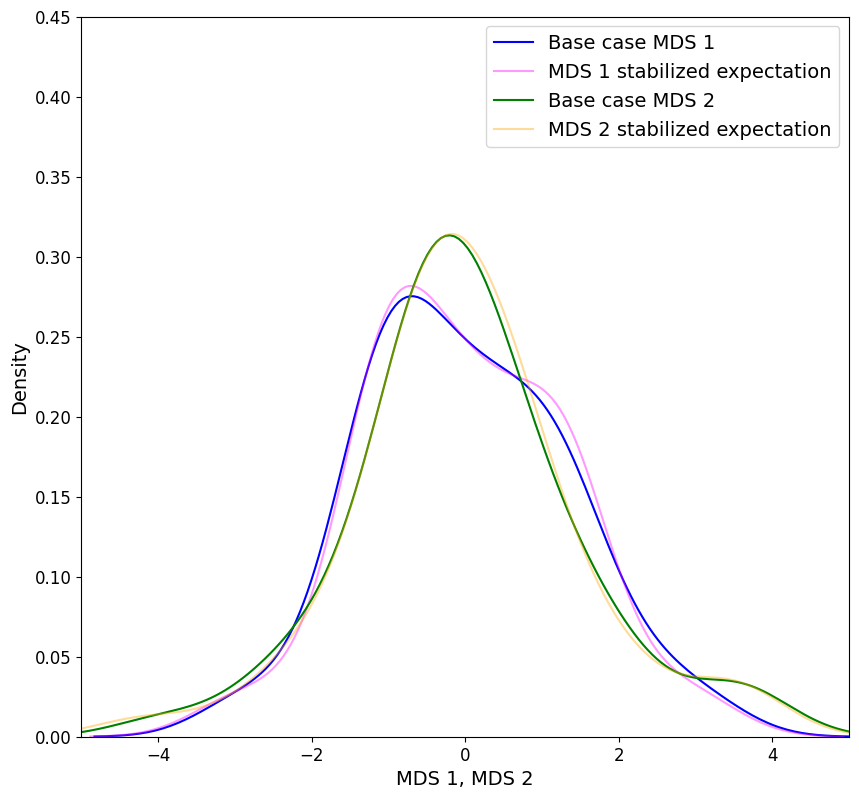

In [37]:
xmin2 = -5
xmax2 = 5
ymin2 = 0.0
ymax2 = 0.45

obj2.expect_plotter(r_idx=bc_idx, Lx=Ax, Ly=Ay, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, save=True)

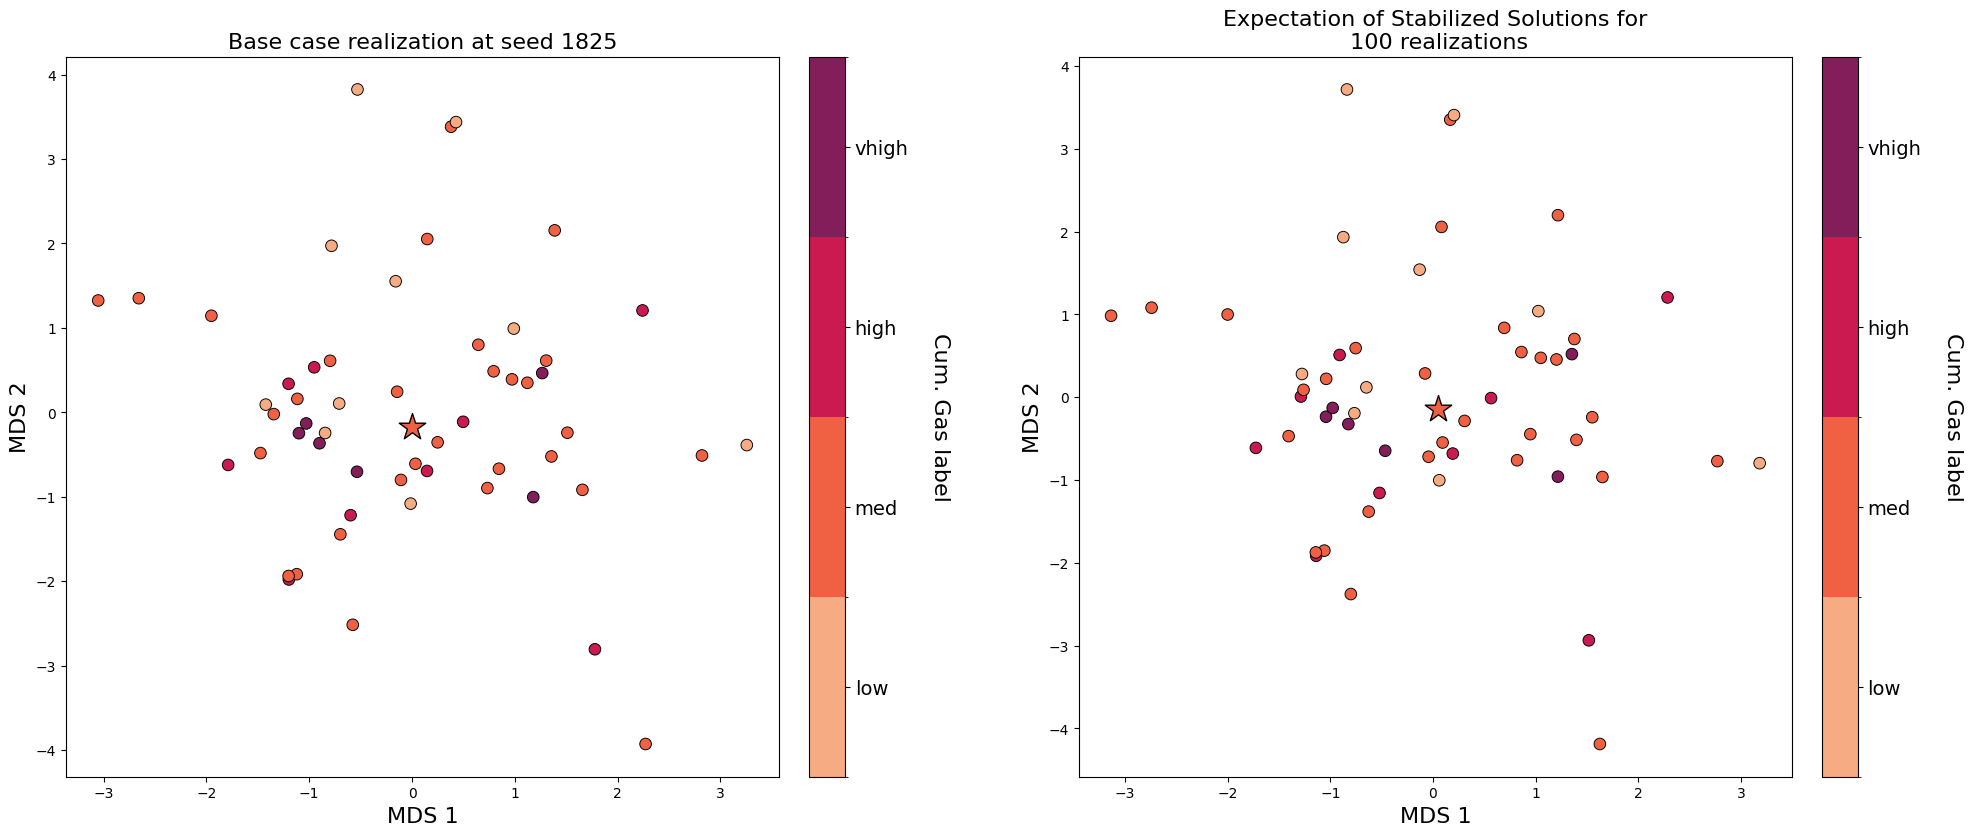

In [38]:
obj2.compare_plot(response=response, r_idx=bc_idx, Ax=Ax, Ay=Ay, x_off=x_off, y_off=y_off, n_case=False, annotate=False, cmap=dpalette, save=True)

Find the convex hull polygon of the expected stabilized solution for all realizations in the N+1 scenario

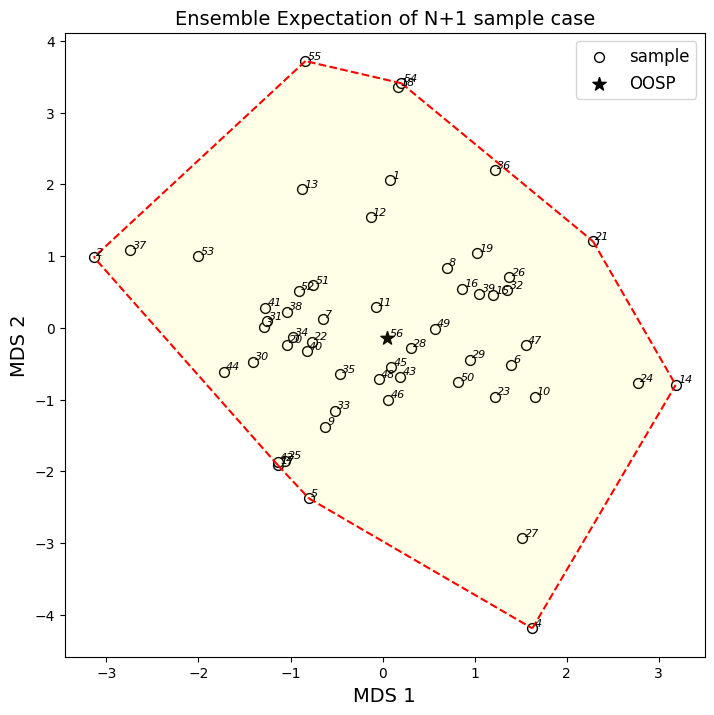

In [39]:
my_points_expected, hull_expected, vertices_expected = obj2.convex_hull(array=E2, num_OOSP=num_OOSP, title='Ensemble Expectation of N+1 sample case', x_off=0.025, y_off=0.03, Ax=Ax, Ay=Ay, make_figure=make_figure, expectation_compute=True, n_case=False, save=True) #0.01,0.015

Stabilize the anchors from the N+1 case to match the N-case such that the same representation is obtained and visualize, then find stabilized expected anchor representation and visualize

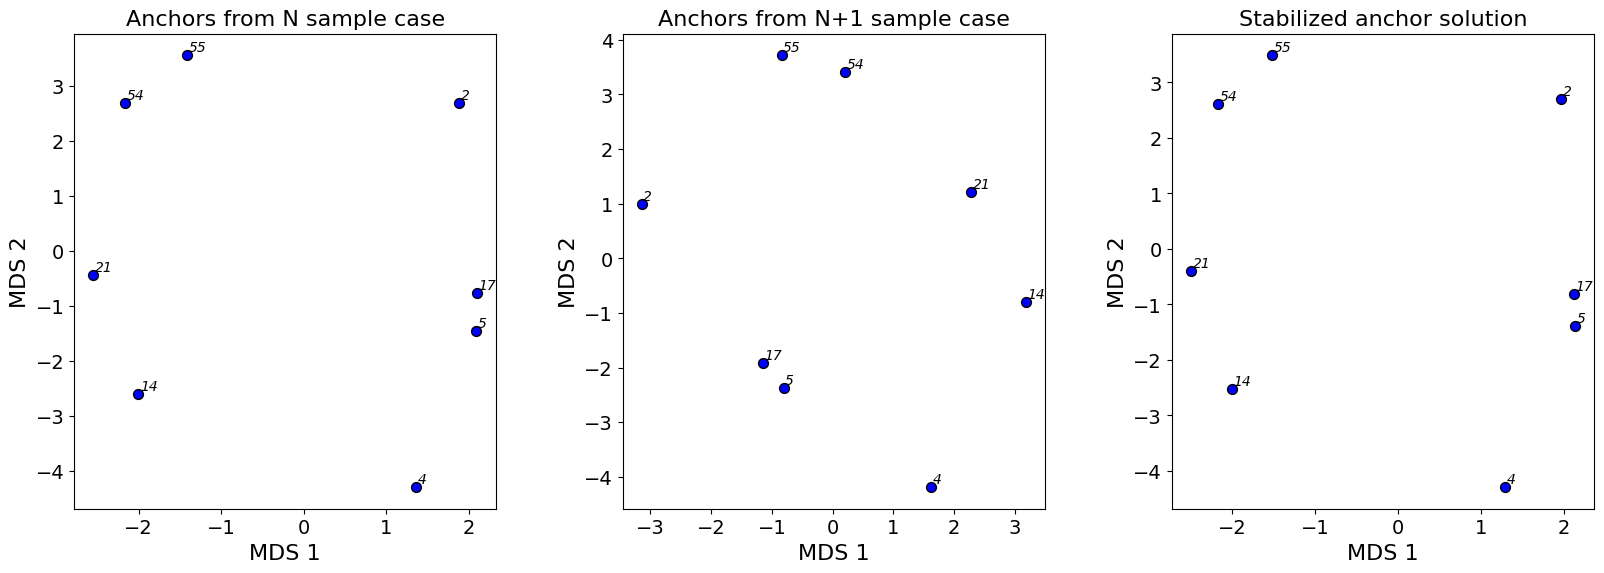

In [40]:
anchors1_exp, anchors2_exp, R_anchors_exp, t_anchors_exp, rmse_err_anchors_exp, stable_coords_anchors_exp, stable_coords_alldata_exp, rmse_err_alldata_exp = obj2.stabilize_anchors(array1=my_points, array2=my_points_expected, hull_1=hull, hull_2=hull_expected, normalize_projections=normalize_projections)

obj2.stable_anchor_visuals( Ax=Ax, Ay=Ay, x_off=x_off, y_off=y_off)

In [41]:
obj2.stable_representation(title='Stabilized Ensemble Expectation for N-sample case',make_figure=False, Ax=Ax, Ay=Ay, annotate=False, x_off=x_off, y_off=y_off)

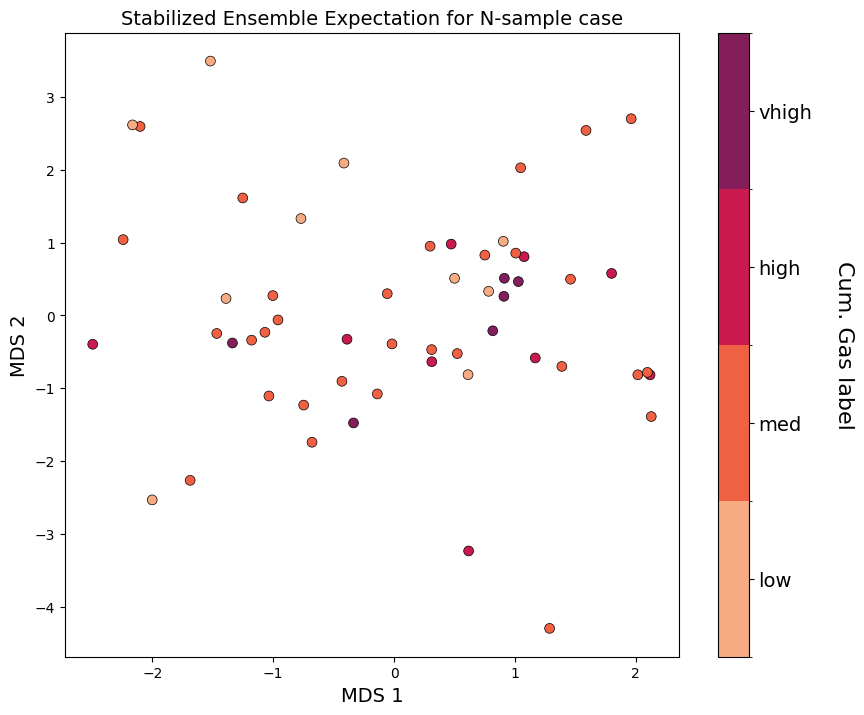

In [42]:
obj2.stabilized_all_plotter(dataframe=df_subset2, hue_=response, palette_=1, annotate=False, n_case=True, save=True)

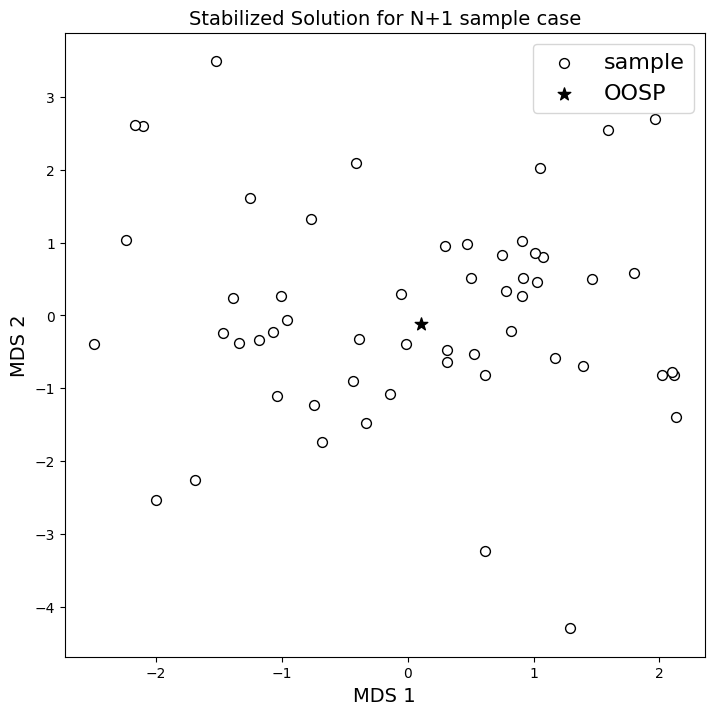

In [43]:
obj2.stable_representation(title='Stabilized Solution for N+1 sample case', Ax=Ax, Ay=Ay, annotate=False, x_off=x_off, y_off=y_off)

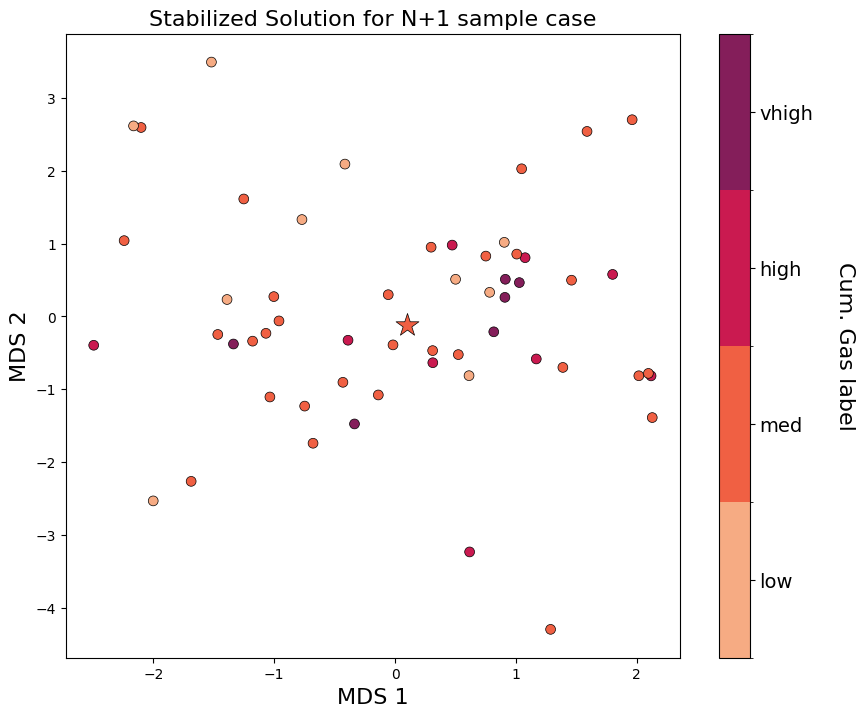

In [44]:
obj2.stabilized_all_plotter(dataframe=df_subset2, hue_=response, palette_=1, annotate=False, n_case=False, save=True)

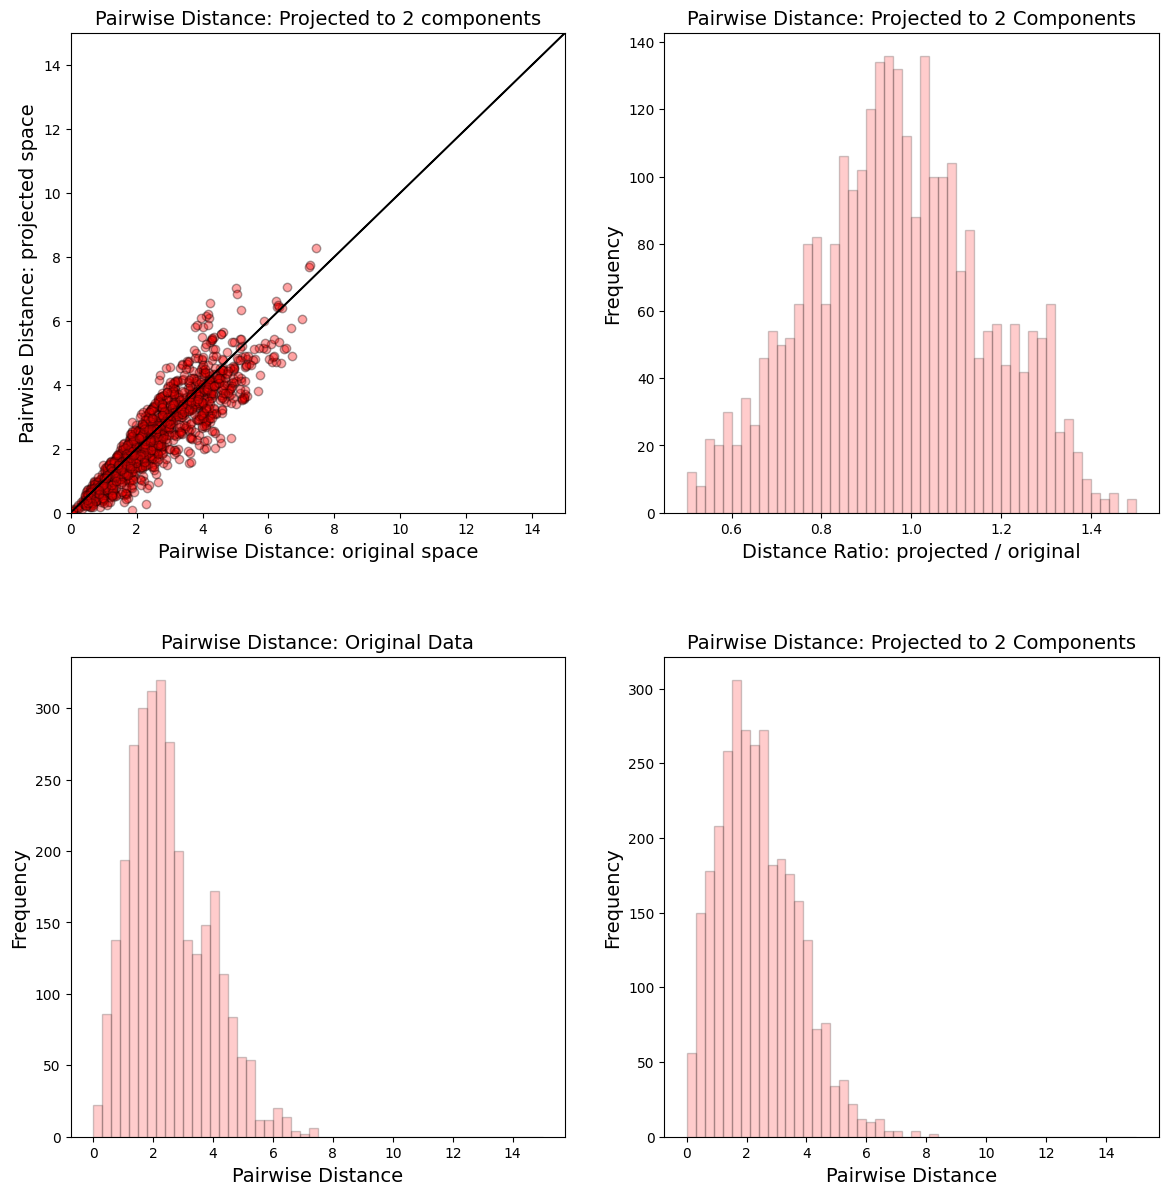

Distance Ratio, mean: 0.9469, standard deviation: 0.2339.


In [45]:
obj2.visual_model_check(norm_type='L2', fig_name='Model check for the stabilized solution of N+1 case samples', array=E2, expectation_compute=True, save=True)

In [46]:
print("The average, minimum, and maximum stress values for the realizations in the N-sample case are ", round(np.mean(norm_stress),5) , round(np.min(norm_stress),5)
      , round(np.max(norm_stress),5))

print("The average, minimum, and maximum stress values for the realizations in the N+1 sample case are ", round(np.mean(norm_stress2),5) , round(np.min(norm_stress2),5)
      , round(np.max(norm_stress2),5))

print("The stress ratio is ",  round((np.mean(norm_stress2)/np.mean(norm_stress)), 5))

The average, minimum, and maximum stress values for the realizations in the N-sample case are  0.19434 0.19401 0.1955
The average, minimum, and maximum stress values for the realizations in the N+1 sample case are  0.19372 0.19314 0.20575
The stress ratio is  0.99679


In [47]:
#  Define parameters needed
xcol = 'X'
ycol = 'Y'
kriging_response_euclidean = krig_array_euc
kriging_response_mds = krig_array_lds
x_labels = ['East (Km)','MDS 1']
y_labels = ['North (Km)','MDS 2']
cb_title = prodname
cmap = 'plasma'
offset_eucl_x = (0.995, 1.005)
offset_eucl_y = (0.9995, 1.0005)
offset_mds_x = (1.05, 1.05) # for MDS, consider negatives values present in range
offset_mds_y = (1.05, 1.05) # for MDS, consider negatives values present in range

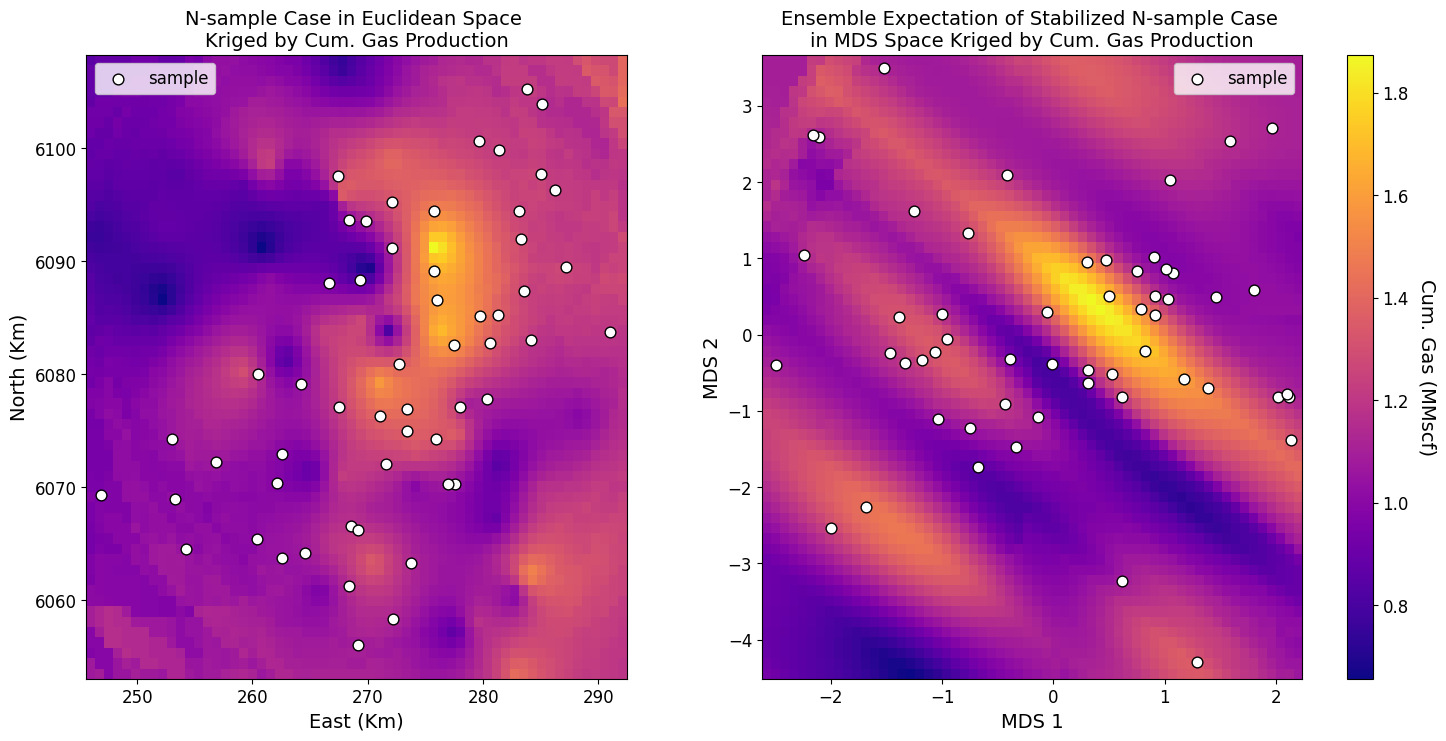

In [48]:
titles = ['N-sample Case in Euclidean Space \nKriged by Cum. Gas Production','Ensemble Expectation of Stabilized N-sample Case \nin MDS Space Kriged by Cum. Gas Production']
subplot_titles = titles

obj2.stabilized_kriging_plotter(xcol=xcol, ycol=ycol, kriging_response_euclidean=krig_array_euc, kriging_response_mds=krig_array_lds, subplot_titles=titles,
                                   x_labels=x_labels, y_labels=y_labels, cb_title=cb_title, cmap=cmap, offset_eucl_x=offset_eucl_x, offset_eucl_y=offset_eucl_y,
                                   offset_mds_x=offset_mds_x, offset_mds_y=offset_mds_y, n_case=True, save=True)

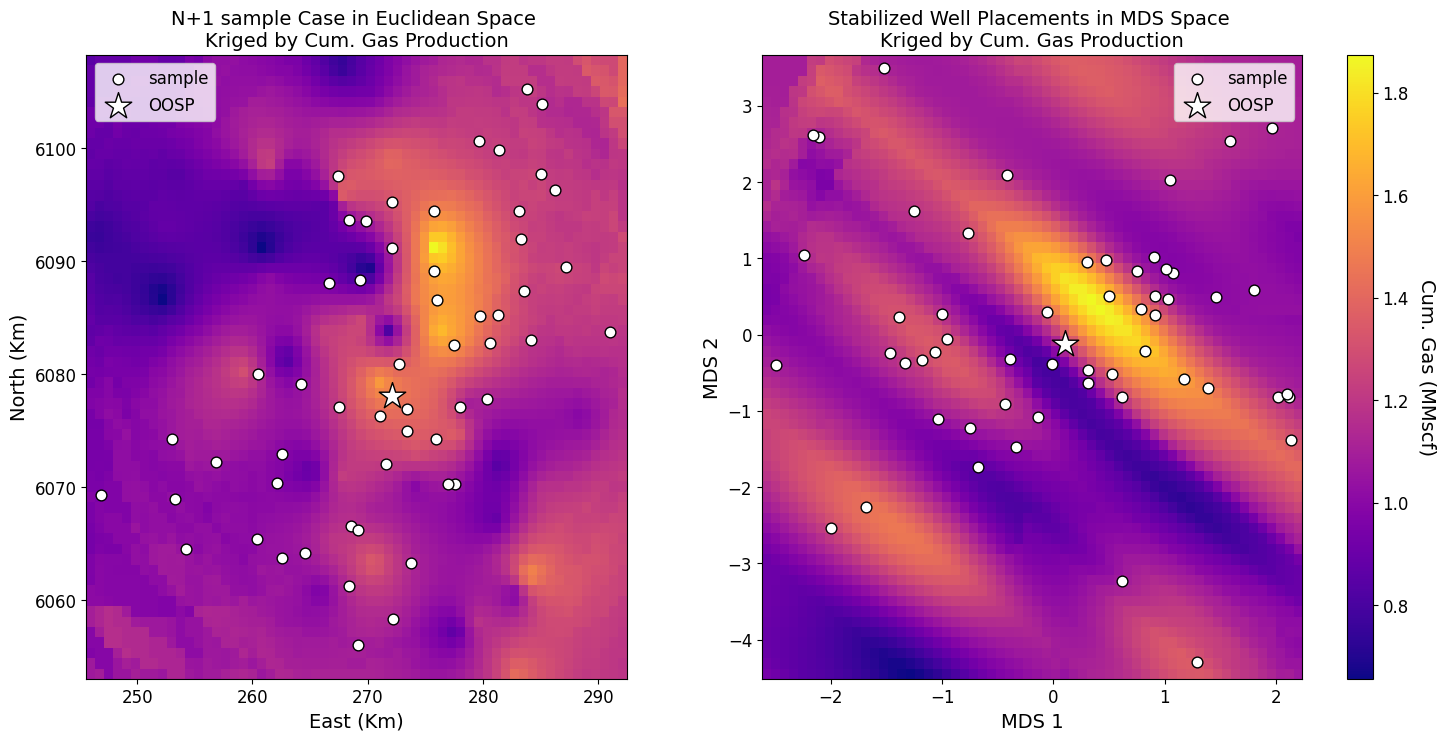

In [49]:
titles = ['N+1 sample Case in Euclidean Space \nKriged by Cum. Gas Production','Stabilized Well Placements in MDS Space \nKriged by Cum. Gas Production']
subplot_titles = titles

obj2.stabilized_kriging_plotter(xcol=xcol, ycol=ycol, kriging_response_euclidean=krig_array_euc, kriging_response_mds=krig_array_lds, subplot_titles=titles,
                                   x_labels=x_labels, y_labels=y_labels, cb_title=cb_title, cmap=cmap, offset_eucl_x=offset_eucl_x, offset_eucl_y=offset_eucl_y,
                                   offset_mds_x=offset_mds_x, offset_mds_y=offset_mds_y, n_case=False, save=True)

# Section 3: Predictor magnitude variations

To highlight the capabilities of the workflow. Let's vary the magnitude of porosity as a predictor feature for the OOSP and see how it moves in the LDS, which helps make powerful and accurate inferences.

In [50]:
multiplier = [0.90, 0.95, 1.00, 1.05, 1.10]
vcol1 = 'PHI (fraction)'
vcol2 = 'Pore Pressure (Mpa)'
vcol3 = 'So (fraction)'
offset_mds_x = (1.1, 1.05)
offset_mds_y = (1.1, 1.05)

In [51]:
def single_pred_curate(data, num_OOSP, multiplier, vcol1):

    # Create empty list and array
    list_xmin2 = []
    list_xmax2 = []
    list_ymin2 = []
    list_ymax2 = []
    lds_arrays = np.empty((0,2))

    for i, factor in enumerate(multiplier):

        data_ = data.copy()
        data_.loc[len(data_)-num_OOSP, vcol1] = factor * data_.loc[len(data_)-num_OOSP, vcol1]

        # Instantiate the class
        obj_ = RT.RigidTransf_NPlus(df=data_, features=features, num_OOSP=num_OOSP, idx=idx,
                                   num_realizations=2, base_seed=base_seed,
                                   start_seed=start_seed, stop_seed=stop_seed,
                                   dissimilarity_metric=dissimilarity_metric, dim_projection=dim_projection,
                                   custom_dij=None)
        # Run rigid MDS
        random_seeds_, all_real_, calc_real_, all_rmse_, norm_stress_ = obj_.run_rigid_MDS(
            normalize_projections=normalize_projections)

        # Convex hull polygon
        my_points_, hull_, vertices_ = obj_.convex_hull(array=all_real_, num_OOSP=num_OOSP,
                                                       title='N+1 sample case', x_off=0.025, y_off=0.03,
                                                       Ax=Ax, Ay=Ay, make_figure=False,
                                                       expectation_compute=False, n_case=False, save=True)

        _, _, _, _, _, _, stable_coords_alldata, _ = obj_.stabilize_anchors(array1=my_points, array2=my_points_,
                                                                           hull_1=hull, hull_2=hull_,
                                                                           normalize_projections=False)

        # Update LDS aray for multiplier realizations run
        lds_arrays = np.concatenate((lds_arrays, stable_coords_alldata), axis=0)

        _ = obj_.stable_representation(title=f'Stabilized N+1 sample case at multiplier={factor} \nfor PHI', Ax=Ax,
                                       Ay=Ay, annotate=False,
                                       x_off=x_off, y_off=y_off, make_figure=False)

        # Create extent for background map and joint color bar for the subplots using X,Y coordinates in MDS space
        xmin2 = np.min(stable_coords_alldata[:, 0])
        xmax2 = np.max(stable_coords_alldata[:, 0])
        ymin2 = np.min(stable_coords_alldata[:, 1])
        ymax2 = np.max(stable_coords_alldata[:, 1])

        # append MDS space extents for different multipliers
        list_xmin2.append(xmin2)
        list_xmax2.append(xmax2)
        list_ymin2.append(ymin2)
        list_ymax2.append(ymax2)

    return list_xmin2, list_xmax2, list_ymin2, list_ymax2, lds_arrays

In [52]:
xmin_lds, xmax_lds, ymin_lds, ymax_lds, all_lds_arrays = single_pred_curate(data = df_subset2, num_OOSP=num_OOSP, multiplier=multiplier, vcol1=vcol1)

In [53]:
def predictor_sensitivity(data, lds_arrays, num_OOSP, multiplier, pred_num, xcol, ycol, kriging_response_euclidean, kriging_response_mds,
                               x_labels, y_labels, cb_title, cmap, offset_eucl_x=(1, 1), offset_eucl_y=(1, 1),
                               offset_mds_x=(1, 1), offset_mds_y=(1, 1), n_case=True):

    cmap2 = plt.cm.get_cmap('Greens')
    K = [kriging_response_euclidean, kriging_response_mds]
    titles = [f'N+1 sample Case in Euclidean Space Kriged \nby Production for {pred_num} Predictor',
                f'Stabilized Well Placements in MDS Space Kriged \nby Production for {pred_num} Predictor for varying multipliers']

    fig, axs = plt.subplots(nrows=1, ncols=2)
    for j in range(len(K)):
        ax = axs[j]

        # Plot making part of function!
        k1min = kriging_response_euclidean.min()
        k2min = kriging_response_mds.min()
        k1max = kriging_response_euclidean.max()
        k2max = kriging_response_mds.max()

        # Create extent for background map and joint color bar for the subplots using X,Y coordinates
        # Feature Space
        xmin = data[xcol].min() * offset_eucl_x[0]
        xmax = data[xcol].max() * offset_eucl_x[1]
        ymin = data[ycol].min() * offset_eucl_y[0]
        ymax = data[ycol].max() * offset_eucl_y[1]

        # MDS Space
        xmin2 = np.min(xmin_lds) * offset_mds_x[0]
        xmax2 = np.max(xmax_lds) * offset_mds_x[1]
        ymin2 = np.min(ymin_lds) * offset_mds_y[0]
        ymax2 = np.max(ymax_lds) * offset_mds_y[1]

        # Split all lds arrays into individual array with len(multiplier)
        lds_arrays_split = np.split(lds_arrays, len(multiplier))

        # Make dataframe for stabilized samples in LDS
        df_lds = pd.DataFrame(lds_arrays_split[0], columns=[xcol, ycol])

        # Obtain input for plot making
        Xmins = [xmin, xmin2]
        Xmaxs = [xmax, xmax2]
        Ymins = [ymin, ymin2]
        Ymaxs = [ymax, ymax2]
        Vmin = [k1min, k2min]
        Vmax = [k1max, k2max]
        df_list = [data, df_lds]
        X = [xcol, xcol]
        Y = [ycol, ycol]

        # For plot making
        im1 = ax.imshow(K[j], vmin=Vmin[j], vmax=Vmax[j], extent=(Xmins[j], Xmaxs[j], Ymins[j], Ymaxs[j]), aspect=1,
                        cmap=cmap, interpolation=None, origin='lower')

        ax.set_title(titles[j], size=16)
        ax.set_xlabel(x_labels[j], size=16)
        ax.set_ylabel(y_labels[j], size=16)
        ax.tick_params(axis='both', which='major', labelsize=14)

    if n_case:
        ax.scatter(df_list[j][X[j]][:-num_OOSP], df_list[j][Y[j]][:-num_OOSP], c='white', s=60,
                           alpha=1.0, linewidths=1.0, edgecolors="black", label='sample')
    else:
        for i, factor in enumerate(multiplier):
            # Make dataframe for stabilized samples in LDS
            df_lds = pd.DataFrame(lds_arrays_split[i], columns=[xcol, ycol])
            df_list = [data, df_lds]

            # Calculate gradient color value based on the multiplier value
            color_value = i/(len(multiplier) - 1)
            color = cmap2(color_value)

            if factor == 1.0:
                # For Original OOSP left hand subplot
                axs[0].scatter(
                    df_list[0][X[0]][:(len(df_list[0]) - num_OOSP)],
                    df_list[0][Y[0]][:(len(df_list[0]) - num_OOSP)],
                    c='white',
                    s=60,
                    alpha=1.0,
                    linewidths=1.0,
                    edgecolors="black",
                    label='sample'
                )

                axs[0].scatter(
                    df_list[0][X[0]][(len(df_list[0]) - num_OOSP):],
                    df_list[0][Y[0]][(len(df_list[0]) - num_OOSP):],
                    marker='*',
                    c=color,
                    #c='white',
                    s=400,
                    alpha=1.0,
                    linewidths=1.0,
                    edgecolors="black",
                    label='OOSP at multiplier=1.0'
                )

                # For original OOSP right hand subplot
                axs[1].scatter(
                    df_list[1][X[1]][:(len(df_list[1]) - num_OOSP)],
                    df_list[1][Y[1]][:(len(df_list[1]) - num_OOSP)],
                    c='white',
                    s=60,
                    alpha=1.0,
                    linewidths=1.0,
                    edgecolors="black",
                    #label='sample'
                )

                axs[1].scatter(
                    df_list[1][X[1]][(len(df_list[1]) - num_OOSP):],
                    df_list[1][Y[1]][(len(df_list[1]) - num_OOSP):],
                    marker='*',
                    c= color,
                    s=400,
                    alpha=1.0,
                    linewidths=1.0,
                    edgecolors="black",
                    label='OOSP at multiplier=1.0'
                )

                axs[0].legend(loc='lower left', fontsize=12)
                axs[0].set_aspect('auto')

            elif factor != 1.0:
                # For modified OOSP's
                axs[1].scatter(
                        df_list[1][X[1]][(len(df_list[1]) - num_OOSP):],
                        df_list[1][Y[1]][(len(df_list[1]) - num_OOSP):],
                        marker='*',
                        c=[color],
                        # c='white',
                        s=400,
                        alpha=1.0,
                        linewidths=1.0,
                        edgecolors="black",
                        label=f'OOSP at multiplier={factor}'
                    )
                axs[1].legend(loc='lower left', fontsize=12)
                axs[1].set_aspect('auto')


    # Aesthetics for plot
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.9, top=1.3, wspace=0.25, hspace=0.3)
    cbar_ax = fig.add_axes([1.97, 0., 0.04, 1.3])  # Left, bottom, width, length
    cbar = fig.colorbar(im1, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(cb_title, rotation=270, labelpad=20, size=14)
    plt.savefig( 'single_pred_sensitivity.tif', dpi=300, bbox_inches='tight')
    plt.show()

Using a numerical multiplier as a factor to change the porosity value for the OOSP, we can see how the OOSP moves in the LDS even though its location is fixed in Euclidean space.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


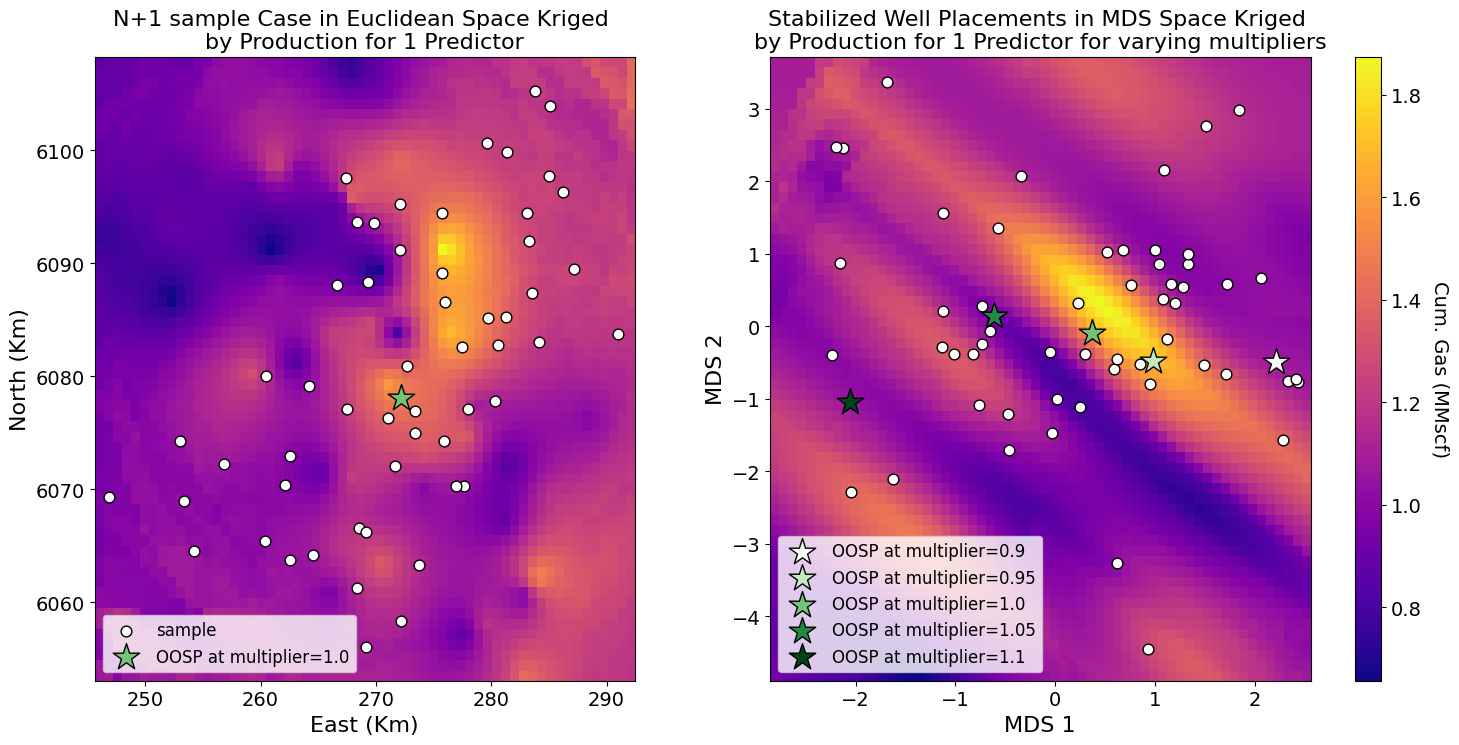

In [54]:
predictor_sensitivity(data = df_subset2, lds_arrays=all_lds_arrays, num_OOSP=num_OOSP, multiplier=multiplier, pred_num=1, xcol=xcol, ycol=ycol, kriging_response_euclidean=krig_array_euc, kriging_response_mds=krig_array_lds, x_labels=x_labels, y_labels=y_labels, cb_title=cb_title, cmap=cmap, offset_eucl_x=offset_eucl_x, offset_eucl_y=offset_eucl_y,offset_mds_x=offset_mds_x, offset_mds_y=offset_mds_y, n_case=False)

Next, change the magnitude of two predictor features for example, porosity and pore pressure at the same time for the OOSP and see how it changes the LDS, while visualizing the Euclidean space at the same time. This can be done for a plethora of combinations such that the location and petrophysical properties of a new well can be mapped alongside its production value.

In [55]:
def multi_pred_curate(data, num_OOSP, multiplier, vcol1, vcol2, vcol3):

    # Create empty list and array
    list_xmin2 = []
    list_xmax2 = []
    list_ymin2 = []
    list_ymax2 = []
    lds_arrays = np.empty((0,2))

    # # Create reverse multiplier
    # reverse_factor = sorted(multiplier, reverse=True)

    for i, factor in enumerate(multiplier):

        data_ = data.copy()
        data_.loc[len(data_)-num_OOSP, vcol1] = factor * data_.loc[len(data_)-num_OOSP, vcol1]
        data_.loc[len(data_)-num_OOSP, vcol2] = factor * data_.loc[len(data_)-num_OOSP, vcol2]
        # data_.loc[len(data_)-num_OOSP, vcol3] = reverse_factor[i] * data_.loc[len(data_)-num_OOSP, vcol3]

        # Instantiate the class
        obj_ = RT.RigidTransf_NPlus(df=data_, features=features, num_OOSP=num_OOSP, idx=idx,
                                   num_realizations=2, base_seed=base_seed,
                                   start_seed=start_seed, stop_seed=stop_seed,
                                   dissimilarity_metric=dissimilarity_metric, dim_projection=dim_projection,
                                   custom_dij=None)
        # Run rigid MDS
        random_seeds_, all_real_, calc_real_, all_rmse_, norm_stress_ = obj_.run_rigid_MDS(
            normalize_projections=normalize_projections)

        # Convex hull polygon
        my_points_, hull_, vertices_ = obj_.convex_hull(array=all_real_, num_OOSP=num_OOSP,
                                                       title='N+1 sample case', x_off=0.025, y_off=0.03,
                                                       Ax=Ax, Ay=Ay, make_figure=False,
                                                       expectation_compute=False, n_case=False, save=True)

        _, _, _, _, _, _, stable_coords_alldata, _ = obj_.stabilize_anchors(array1=my_points, array2=my_points_,
                                                                           hull_1=hull, hull_2=hull_,
                                                                           normalize_projections=False)

        # Update LDS aray for multiplier realizations run
        lds_arrays = np.concatenate((lds_arrays, stable_coords_alldata), axis=0)

        _ = obj_.stable_representation(title=f'Stabilized N+1 sample case at multiplier={factor} \nfor PHI', Ax=Ax,
                                       Ay=Ay, annotate=False,
                                       x_off=x_off, y_off=y_off, make_figure=False)

        # Create extent for background map and joint color bar for the subplots using X,Y coordinates in MDS space
        xmin2 = np.min(stable_coords_alldata[:, 0])
        xmax2 = np.max(stable_coords_alldata[:, 0])
        ymin2 = np.min(stable_coords_alldata[:, 1])
        ymax2 = np.max(stable_coords_alldata[:, 1])

        # append MDS space extents for different multipliers
        list_xmin2.append(xmin2)
        list_xmax2.append(xmax2)
        list_ymin2.append(ymin2)
        list_ymax2.append(ymax2)

    return list_xmin2, list_xmax2, list_ymin2, list_ymax2, lds_arrays

In [56]:
xmin_lds2, xmax_lds2, ymin_lds2, ymax_lds2, all_lds_arrays2 = multi_pred_curate(data = df_subset2, num_OOSP=num_OOSP, multiplier=multiplier, vcol1=vcol1, vcol2=vcol2, vcol3=vcol3)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


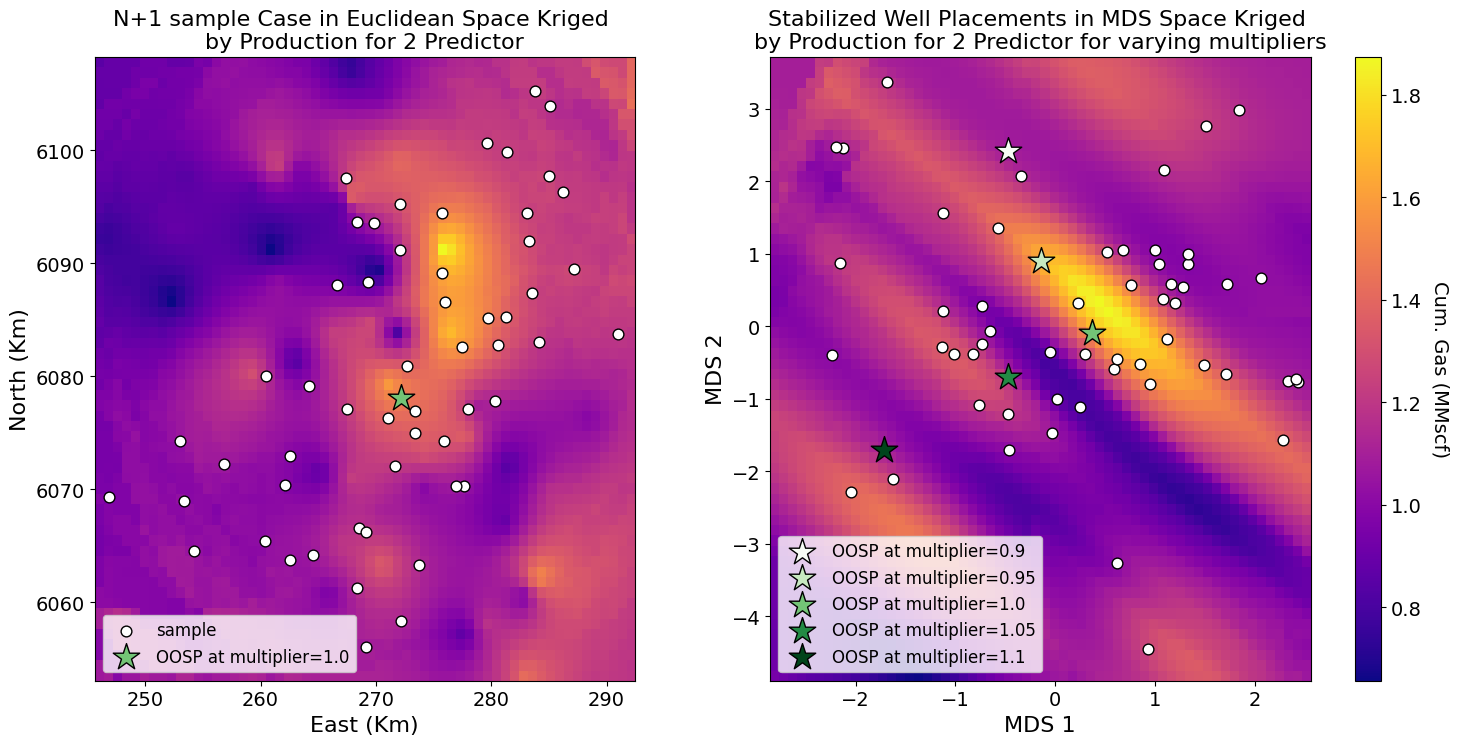

In [57]:
predictor_sensitivity(data = df_subset2, lds_arrays=all_lds_arrays2, num_OOSP=num_OOSP, multiplier=multiplier, pred_num=2, xcol=xcol, ycol=ycol, kriging_response_euclidean=krig_array_euc, kriging_response_mds=krig_array_lds, x_labels=x_labels, y_labels=y_labels, cb_title=cb_title, cmap=cmap, offset_eucl_x=offset_eucl_x, offset_eucl_y=offset_eucl_y,offset_mds_x=offset_mds_x, offset_mds_y=offset_mds_y, n_case=False)